In [3]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import glob
import datetime
import time
import sys
import os
import tables

#from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from datetime import datetime
from scipy.special import expit


from gensim import corpora, models

pd.set_option('display.max_columns', None)

C:\ProgramData\Anaconda2\envs\py360\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
C:\ProgramData\Anaconda2\envs\py360\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [5]:
# !pip install tables
# !pip install bs4

# Load custom modules

These are downloaded to the Github repo from the MSD website. 
The original code was written in python 2, so some minor updates are needed to ensure they run in python 3.
To load the dataset, we need to clone the repo and add the directory that the python source files are saved in to your system path so that they can be imported. 

In [6]:
# Check current working directory
cur_dir = os.getcwd()
print("current dir:", cur_dir)

current dir: C:\Users\rgupta25\MSDSongs


In [7]:
# Add MSD source code to your sys path so that the imports will work
# Change to wherever the github repo is cloned and point to the folder with the python source code from the repo 'PythronSrc'
sys.path.append(r'D:/Users/rgupta25/Documents/GitHub/CS109B_MSD/MSongsDB_code/PythonSrc/')

# Use the code saved in github rather than the original from the labROSA website
# The report version has edits to switch from python 2 to python 3 (more may be needed if we use other modules)
import hdf5_getters as GETTERS
import hdf5_utils as HDF5

need pg module and MBrainzDB folder of Python source code if you
want to use musicbrainz related functions, e.g. fill_hdf5_from_musicbrainz


# Load all of the subset data

First, we have to ave the uncompressed subset locally. Subset data is available here: http://static.echonest.com/millionsongsubset_full.tar.gz

This part of the notebook loads all of the data in the subset files to a dataframe.

In [8]:
# Path to the Million Song Dataset subset (uncompressed) - change to the location on your laptop
# Cannot store this on github as it is too large
msd_subset_path = 'D:/Users/rgupta25/Desktop/MSDS/Dataset/millionsongsubset_full/MillionSongSubset/'

# Keep these - folders match the structure of the uncompressed file
msd_subset_data_path = os.path.join(msd_subset_path, 'data')
msd_subset_addf_path = os.path.join(msd_subset_path, 'AdditionalFiles')

I scraped the explanation of the fields from the website below. 

In [9]:
# Dataset file reference - scrape this from the labrosa website
import bs4 as bs
import requests

def get_reference_table(print_status = False):
    ''' Scrape the reference table for field names '''
    # Use cached version of the site since the main site is currently down
    target_url = 'https://webcache.googleusercontent.com/search?q=cache:D5jClkFvR94J:https://labrosa.ee.columbia.edu/millionsong/faq+&cd=6&hl=en&ct=clnk&gl=uk'

    target_page = requests.get(target_url)
    if print_status:
        print('Status code:',target_page.status_code)

    soup = bs.BeautifulSoup(target_page.text, 'html.parser')
    
    first_table = soup.find('table')
    table_rows = first_table.findAll('tr')

    # Extract all of the rows in the table
    table_extract = []
    for i in range(0, len(table_rows)):
        temp = table_rows[i].text.split('\n')
        table_extract.append(temp)
        
    # Tidy up outputs
    table_extract = pd.DataFrame(table_extract)
    table_extract = table_extract[[1, 2, 3]]
    table_extract.columns = table_extract.iloc[0]
    
    return table_extract[1:]

In [10]:
# Run the scraping function and check the table
field_reference = get_reference_table()
field_reference

,Field name,Type,Description
1,analysis sample rate,float,sample rate of the audio used
2,artist 7digitalid,int,ID from 7digital.com or -1
3,artist familiarity,float,algorithmic estimation
4,artist hotttnesss,float,algorithmic estimation
5,artist id,string,Echo Nest ID
6,artist latitude,float,latitude
7,artist location,string,location name
8,artist longitude,float,longitude
9,artist mbid,string,ID from musicbrainz.org
10,artist mbtags,array string,tags from musicbrainz.org


Only a few fields have missing data in the form of NaN, but that's not an accurate picture since it is coded as blanks or 0's elsewhere.

In [11]:
msd_fullset_path = r'D:/Users/rgupta25/Desktop/MSDS/FullDataset/MillionSongDataset/all/'

In [12]:
#load the entire file
fullset_full = pd.read_csv(msd_fullset_path+'song_info.csv',sep =';')

In [13]:
fullset_full.shape

(1000000, 27)

In [14]:
fullset_full.head()

,track_id,audio_md5,end_of_fade_in,start_of_fade_out,analysis_sample_rate,duration,loudness,tempo,key,key_confidence,mode,mode_confidence,time_signature,time_signature_confidence,danceability,energy,artist_id,artist_name,artist_location,artist_familiarity,artist_hotttnesss,genre,release,song_id,title,song_hotttnesss,year
0,TRAAAAK128F9318786,7b6557889cc46b202300a4baf902e229,0.000,210.048,22050,213.94240,-4.769,99.944,1,0.349,1,0.403,4,0.846,0,0,ARJNIUY12298900C91,Adelitas Way,NaN,0.639903,0.461318,NaN,Adelitas Way,SOBLFFE12AF72AA5BA,Scream,0.733372,2009
1,TRAAAAV128F421A322,c13fd321975ce498a513ce1a39167bda,0.264,115.142,22050,118.07302,-7.240,125.475,7,0.187,1,0.425,4,0.546,0,0,AR73AIO1187B9AD57B,Western Addiction,"San Francisco, CA",0.671755,0.386606,NaN,Cognicide,SOQPWCR12A6D4FB2A3,A Poor Recipe For Civic Cohesion,0.481694,2005
2,TRAAAAW128F429D538,a222795e07cd65b7a530f1346f520649,0.247,218.932,22050,218.93179,-11.197,92.198,1,0.736,0,0.636,4,0.778,0,0,ARD7TVE1187B99BFB1,Casual,California - LA,0.581794,0.401998,NaN,Fear Itself,SOMZWCG12A8C13C480,I Didn't Mean To,0.602120,0
3,TRAAAAY128F42A73F0,98f8f6d350143b93d7a3337db80036b6,0.000,182.898,22050,193.01832,-13.179,41.279,2,0.760,1,0.803,4,0.000,0,0,ARL752Q1187FB35EFE,Alquimia,Mexico,0.476941,0.307080,NaN,Forever,SOJDASC12A8C13EB49,The Lark In The Clear Air,0.000000,0
4,TRAAABD128F429CF47,bb9771eeef3d5b204a3c55e690f52a91,0.148,137.915,22050,148.03546,-9.843,121.274,6,0.169,0,0.430,4,0.384,0,0,ARMJAGH1187FB546F3,The Box Tops,"Memphis, TN",0.630630,0.417500,NaN,Dimensions,SOCIWDW12A8C13D406,Soul Deep,NaN,1969


# EDA - simple numerical fieldss

This part explore the simple numerical fields - other columns require more investigation and processing.  

Notes on data cleaning:
* `Song_hotttnesss` is missing for 43% of the rows. 
* Several columns are non-informative and can be dropped:
    * `Analysis sample rate`: is the same value for all tracks
    * `Energy` and `Danceability`: contain only zeros
    * `Artist latitude` and `longitude`: have more than 60% missing data
* `Year` has around 25% of rows with zero, which can be considered missing data. These are left as they are for now. 

lets check the unique id that identifies a song in the dataset. We will use this id for merging this data with other datasets wherever necessary


In [15]:
#lets check the uninque id that identifies a song in the dataset
print(fullset_full.track_id.nunique())
print(fullset_full.song_id.nunique())
print(fullset_full.artist_id.nunique())

1000000
999056
44745


In [16]:
fullset_full.describe()

,end_of_fade_in,start_of_fade_out,analysis_sample_rate,duration,loudness,tempo,key,key_confidence,mode,mode_confidence,time_signature,time_signature_confidence,danceability,energy,artist_familiarity,artist_hotttnesss,genre,song_hotttnesss,year
count,1000000.000000,1000000.000000,1000000.0,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.0,1000000.0,999815.000000,999988.000000,0.0,581965.000000,1000000.000000
mean,0.819850,240.625024,22050.0,249.500755,-10.124039,123.889218,5.321964,0.442496,0.666408,0.472109,3.593947,0.515916,0.0,0.0,0.557203,0.379813,NaN,0.356051,1030.325652
std,3.304457,124.079924,0.0,126.229636,5.197245,35.055981,3.601595,0.276719,0.471496,0.192613,1.221925,0.371903,0.0,0.0,0.138611,0.125960,NaN,0.234441,998.745002
min,0.000000,0.313000,22050.0,0.313020,-58.178000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,NaN,0.000000,0.000000
25%,0.000000,173.180000,22050.0,180.740770,-12.672000,97.995000,2.000000,0.212000,0.000000,0.356000,3.000000,0.125000,0.0,0.0,0.478253,0.336324,NaN,0.215080,0.000000
50%,0.194000,219.759000,22050.0,228.858320,-8.963000,122.086000,5.000000,0.462000,1.000000,0.483000,4.000000,0.557000,0.0,0.0,0.558905,0.386194,NaN,0.377532,1969.000000
75%,0.432000,279.713000,22050.0,289.932610,-6.386000,144.089000,9.000000,0.652000,1.000000,0.602000,4.000000,0.869000,0.0,0.0,0.641420,0.444066,NaN,0.531985,2002.000000
max,1163.941000,3030.622000,22050.0,3034.905670,4.318000,302.300000,11.000000,1.000000,1.000000,1.000000,7.000000,1.000000,0.0,0.0,1.000000,1.082503,NaN,1.000000,2011.000000


song or track id both are unique, and hence can be used for merging with other datasets

In [17]:
# Select set of columns
cols_to_explore = ['song_hotttnesss', 'artist_familiarity', 'artist_hotttnesss', 
                   'danceability', 'duration', 'energy', 'key', 'loudness', 'mode', 'tempo', 'year'
]
data = fullset_full[cols_to_explore]

In [18]:
data.head()

,song_hotttnesss,artist_familiarity,artist_hotttnesss,danceability,duration,energy,key,loudness,mode,tempo,year
0,0.733372,0.639903,0.461318,0,213.94240,0,1,-4.769,1,99.944,2009
1,0.481694,0.671755,0.386606,0,118.07302,0,7,-7.240,1,125.475,2005
2,0.602120,0.581794,0.401998,0,218.93179,0,1,-11.197,0,92.198,0
3,0.000000,0.476941,0.307080,0,193.01832,0,2,-13.179,1,41.279,0
4,NaN,0.630630,0.417500,0,148.03546,0,6,-9.843,0,121.274,1969


Even preliminary exploration shows that there are problems in the data:
Danceability and energy are all 0's. 

In [19]:
data.describe()

,song_hotttnesss,artist_familiarity,artist_hotttnesss,danceability,duration,energy,key,loudness,mode,tempo,year
count,581965.000000,999815.000000,999988.000000,1000000.0,1000000.000000,1000000.0,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,0.356051,0.557203,0.379813,0.0,249.500755,0.0,5.321964,-10.124039,0.666408,123.889218,1030.325652
std,0.234441,0.138611,0.125960,0.0,126.229636,0.0,3.601595,5.197245,0.471496,35.055981,998.745002
min,0.000000,0.000000,0.000000,0.0,0.313020,0.0,0.000000,-58.178000,0.000000,0.000000,0.000000
25%,0.215080,0.478253,0.336324,0.0,180.740770,0.0,2.000000,-12.672000,0.000000,97.995000,0.000000
50%,0.377532,0.558905,0.386194,0.0,228.858320,0.0,5.000000,-8.963000,1.000000,122.086000,1969.000000
75%,0.531985,0.641420,0.444066,0.0,289.932610,0.0,9.000000,-6.386000,1.000000,144.089000,2002.000000
max,1.000000,1.000000,1.082503,0.0,3034.905670,0.0,11.000000,4.318000,1.000000,302.300000,2011.000000


In [20]:
# Drop these useless columns
cols_to_drop = ['danceability', 'energy']
data = data.drop(columns = cols_to_drop)

In [21]:
data.dtypes

song_hotttnesss       float64
artist_familiarity    float64
artist_hotttnesss     float64
duration              float64
key                     int64
loudness              float64
mode                    int64
tempo                 float64
year                    int64
dtype: object

In [22]:
# Around 43% of the files do not have the target variable
# The original dataset has weird spelling of hotness!
missing = fullset_full['song_hotttnesss'].isna().sum() / len(fullset_full)*100
print('Number of songs missing "song hotness": {}%'.format(np.around(missing, 1)))


Number of songs missing "song hotness": 41.8%


In [23]:
# Drop rows without song_hotness values
# We cannot impute data that we are trying to predict
data = data.dropna(subset = ['song_hotttnesss'])

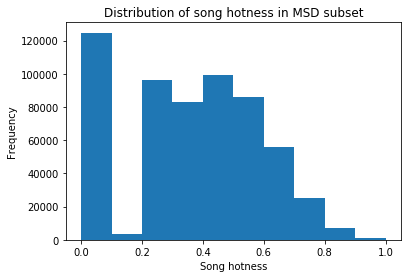

In [24]:
plt.hist(data.song_hotttnesss)
plt.title('Distribution of song hotness in MSD subset')
plt.xlabel('Song hotness')
plt.ylabel('Frequency');

In [25]:
# What percentage are zero?
print('Percentage of remaining records with zero song hotness values: {}%'.format(np.around((data['song_hotttnesss'] == 0).sum() / len(data)*100), 2))
      

Percentage of remaining records with zero song hotness values: 21.0%


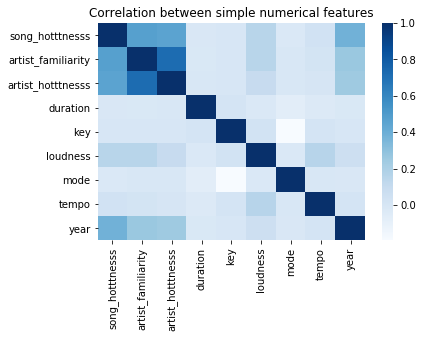

In [26]:
correlations = data.corr()
sns.heatmap(correlations, cmap = 'Blues')
plt.title('Correlation between simple numerical features');

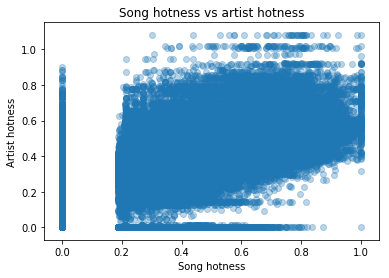

In [27]:
plt.scatter(data['song_hotttnesss'], data['artist_hotttnesss'], alpha = 0.3)
plt.title('Song hotness vs artist hotness')
plt.xlabel('Song hotness')
plt.ylabel('Artist hotness');

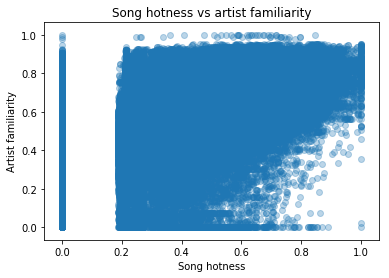

In [28]:
plt.scatter(data['song_hotttnesss'], data['artist_familiarity'], alpha = 0.3)
plt.title('Song hotness vs artist familiarity')
plt.xlabel('Song hotness')
plt.ylabel('Artist familiarity');

There is a slight positive trend of song hotness over time, which makes sense given the way that the metric is measured. We must also consider that musical tastes change over time. 

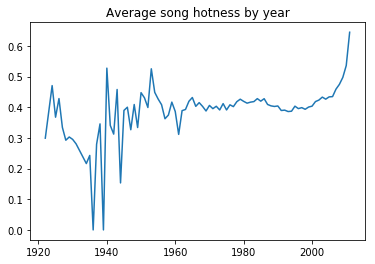

In [29]:
year_plot = data[data['year'] != 0].groupby(['year']).mean().reset_index()
plt.plot(year_plot['year'], year_plot['song_hotttnesss']);
plt.title('Average song hotness by year');

In [30]:
# Check number of years with value 0
print('Number of records with year recorded as zero: {}'.format(sum(data['year'] == 0)))

Number of records with year recorded as zero: 235521


# Merge with other datasets

The basic MSD dataset has some useful fields, but we have to explore whether we can augment this with other information. 

## Genre information

I had a look at whether we can augment the dataset with genre information. Although there is some genre information in the tags, this is mixed with other data like location and it isn't clear which is the main genre. Therefore I have linked with another dataset from Vienna University, available at: http://www.ifs.tuwien.ac.at/mir/msd/download.html


In [31]:
# Read genre info from the website
genres = pd.read_csv('http://www.ifs.tuwien.ac.at/mir/msd/partitions/msd-MAGD-genreAssignment.cls',
                       sep = '\t', 
                       header = None)

genres.columns=['track_id', 'genre_id']
genres.head()

,track_id,genre_id
0,TRAAAAK128F9318786,Pop_Rock
1,TRAAAAV128F421A322,Pop_Rock
2,TRAAAAW128F429D538,Rap
3,TRAAABD128F429CF47,Pop_Rock
4,TRAAACV128F423E09E,Pop_Rock


In [32]:
# Read genre info from the website
styles = pd.read_csv('http://www.ifs.tuwien.ac.at/mir/msd/partitions/msd-MASD-styleAssignment.cls',
                       sep = '\t', 
                       header = None)

styles.columns=['track_id', 'style']
styles.head()

,track_id,style
0,TRAAAAK128F9318786,Metal_Alternative
1,TRAAAAV128F421A322,Punk
2,TRAAAAW128F429D538,Hip_Hop_Rap
3,TRAAACV128F423E09E,Rock_Neo_Psychedelia
4,TRAAAEF128F4273421,Pop_Indie


In [33]:
#lets check whether track_id is unique in genre and style dataset
print(len(genres))
print((genres.track_id.nunique()))
print(len(styles))
print((styles.track_id.nunique()))

422714
422714
273936
273936


track_id is unique in both datasets however we will query how many tracks from genre and style match with main songs dataset

In [34]:
# Merge on track ID
fullset_augmented = fullset_full.merge(genres, 
                                     how = 'left',
                                     on = 'track_id')
fullset_augmented = fullset_augmented.merge(styles, 
                                     how = 'left',
                                     on = 'track_id')

In [35]:
# Boo... more than half are missing - we will have to see if there are other sources that might improve things
fullset_augmented['genre_id'].isna().sum(), fullset_augmented['style'].isna().sum() 


(577286, 726064)

In [36]:
fullset_augmented.shape

(1000000, 29)

## Rhythm Histogram data. 

Copy at https://drive.google.com/open?id=1dNTS0CL5zNy17fOjdusemsiPpnMSuWPp

In [37]:
# rh_data = pd.read_csv(cur_dir + '/../../data/msd-rh.csv.gz', header=None, compression='gzip', escapechar='\'')
rh_data = pd.read_csv(msd_subset_path + '/rythmhist/msd-rh.csv.gz', header=None, compression='gzip', escapechar='\'')



In [38]:
rh_data[60]=rh_data[60].str.replace(',','')

In [39]:
rh_data.shape

(994185, 61)

In [40]:
rh_data.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
count,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000
mean,10.747208,8.804710,7.545514,6.632828,6.130460,5.867655,5.436778,5.082182,5.028319,4.804715,4.618021,4.740827,4.748943,4.393691,4.123987,4.007699,3.873104,3.840052,3.802111,3.541086,3.396043,3.327304,3.236329,3.286237,3.394515,3.193727,3.020321,2.932759,2.786210,2.718177,2.688330,2.645896,2.566184,2.543914,2.508047,2.480911,2.461847,2.444112,2.327892,2.273370,2.198871,2.154295,2.106203,2.074629,2.028703,1.987840,2.001718,2.005123,2.019334,2.081961,2.033919,1.935411,1.858131,1.831933,1.807096,1.770416,1.726511,1.675519,1.657650,1.628000
std,4.745723,3.623742,2.990341,2.773978,2.634145,2.449711,2.267750,2.201609,2.311368,2.184540,2.078767,2.317916,2.554379,2.228124,2.005171,1.984086,1.998282,2.080600,2.131224,1.896828,1.773172,1.753022,1.738909,1.917375,2.334429,2.022861,1.778731,1.738296,1.561588,1.510218,1.483446,1.523024,1.447878,1.484905,1.462194,1.490071,1.487507,1.515765,1.371641,1.329778,1.212377,1.191753,1.148849,1.119682,1.068259,1.067603,1.109623,1.192496,1.327821,1.613612,1.532467,1.239517,1.108285,1.108109,1.113279,1.033209,0.968262,0.903420,0.856319,0.798481
min,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000222,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223
25%,7.434689,6.276521,5.462106,4.695081,4.304360,4.188430,3.869108,3.559366,3.461473,3.320068,3.200542,3.203318,3.127618,2.949085,2.804547,2.712347,2.593171,2.529792,2.472563,2.349306,2.271521,2.222684,2.152268,2.132991,2.095954,2.031689,1.972940,1.919386,1.850632,1.811181,1.791342,1.747137,1.710075,1.688737,1.660016,1.626730,1.606363,1.582164,1.533429,1.506323,1.477017,1.443220,1.418543,1.402386,1.377259,1.349058,1.346721,1.331677,1.318168,1.303640,1.279702,1.264551,1.240451,1.221177,1.199138,1.183471,1.163148,1.138751,1.129876,1.118636
50%,10.114451,8.432142,7.242066,6.364112,5.840643,5.617054,5.205885,4.847803,4.721892,4.527791,4.363730,4.386599,4.293448,4.031709,3.830349,3.704218,3.548375,3.468533,3.403843,3.216387,3.104187,3.035678,2.938959,2.920724,2.884994,2.783797,2.692683,2.611853,2.519052,2.460497,2.433397,2.375835,2.317170,2.283945,2.252322,2.210325,2.184457,2.156495,2.085823,2.047876,2.008082,1.967232,1.932481,1.908927,1.875202,1.836798,1.835027,1.819052,1.805077,1.792123,1.757127,1.737075,1.700535,1.676012,1.644394,1.623440,1.598302,1.562451,1.549573,1.531355
75%,13.363227,10.913700,9.300042,8.262290,7.607399,7.238793,6.734788,6.318180,6.207196,5.941693,5.721525,5.829992,5.772175,5.368905,5.071119,4.915226,4.722922,4.654492,4.593721,4.298268,4.132630,4.040328,3.914323,3.927644,3.931337,3.759103,3.599590,3.482811,3.

In [41]:
rh_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,7.224382,6.109045,6.685568,4.966105,7.842882,2.844719,3.361026,3.442607,2.590563,2.510110,3.489836,2.620875,2.981837,2.658234,1.991701,2.865213,2.446870,2.362090,2.119853,3.402324,3.312368,5.171416,4.306777,2.578843,2.354629,2.439796,2.315009,2.478483,1.720365,1.946930,2.176049,2.151473,1.484158,2.463190,1.587826,1.725714,1.896247,2.057304,1.676314,1.668819,2.377014,2.578647,2.352990,2.619982,7.261864,3.851958,2.034727,1.937198,2.327277,1.400687,1.881342,1.644958,1.651929,1.744542,1.560066,1.471327,1.278020,1.450461,1.744244,1.308790,TRUNNPU128F42509AF
1,14.677012,11.396501,6.471495,6.448495,5.532688,5.459681,4.962178,6.169852,4.361400,4.689114,5.028985,3.808006,3.670783,4.345497,3.470329,3.411302,3.164273,3.066168,2.413340,2.574592,3.005441,2.862182,2.974478,2.755254,2.206445,3.645482,2.236688,3.027635,1.394029,1.890757,1.722798,1.887297,1.530212,1.747953,1.625365,1.359184,1.404816,1.890264,1.235513,1.915746,1.394843,1.474570,1.152636,1.045539,1.150380,1.287604,1.181704,1.323699,1.039293,1.022161,1.062748,1.169235,1.154576,1.056674,0.885865,1.031910,1.069888,0.799239,0.932625,0.920351,TRHOCGC128F4289D7E
2,4.693787,8.161283,4.093479,3.973085,2.508202,2.896735,3.671773,3.639837,2.537774,2.026490,3.067868,2.307508,2.197447,1.665187,6.908271,1.751675,1.326321,1.868806,3.519019,3.226108,2.620849,2.199655,2.716995,1.371609,1.223698,1.662284,2.132717,2.728259,1.563425,10.511957,1.622031,1.747682,1.566627,1.682926,1.433441,1.676330,2.582308,2.296095,1.263071,2.048495,2.075836,1.391475,1.282799,1.161428,5.115295,1.494706,1.646880,1.675094,2.403007,1.378582,2.226650,1.726906,2.274374,1.447875,1.258306,2.076403,1.436256,1.768820,1.088751,5.942637,TRUCDEN128F422F002
3,5.732590,4.595852,4.447026,3.445079,4.157514,3.177737,2.750734,2.316945,2.617048,4.041836,2.595810,2.025904,2.128921,1.868697,1.952426,1.938566,1.718140,1.925044,1.865080,1.869095,1.321608,1.114444,1.108346,1.160560,1.051970,1.033919,1.101187,1.131778,0.973218,1.187626,1.123574,1.042106,0.910357,0.838702,0.685756,0.794708,0.728102,0.646424,1.001201,0.841439,0.633582,0.625806,0.611139,0.695433,0.613495,0.601609,0.581338,0.566299,0.587599,0.512447,0.428625,0.545786,0.512769,0.497109,0.428288,0.464276,0.434104,0.469024,0.454484,0.373569,TRIRBZT128F4248E8E
4,6.782964,4.592204,4.587584,4.003001,2.943357,2.935050,2.497146,2.544335,2.608646,2.228174,2.053194,1.925623,1.829839,2.356808,2.334097,1.979131,2.007416,1.722231,1.474112,1.762297,1.552419,1.745466,3.290660,1.363205,1.413405,1.346467,1.226538,1.289772,1.691532,1.255177,1.459558,1.268531,1.188750,1.616032,1.097459,0.902051,1.417650,1.069397,1.103072,1.104875,1.048233,0.985500,1.136311,0.849429,0.992081,1.692612,1.002904,0.721470,1.133159,0.881244,1.429873,0.927437,1.044928,0.883083,0.772829,0.828493,0.946112,0.790503,0.777186,0.999154,TRURGGS12903CC654D


In [42]:
rh_data = rh_data.add_prefix('rythm_')
rh_data.rename(columns = {'rythm_60': 'track_id'}, inplace = True)

In [43]:
#lets check if track_id is unique in this data
print(len(rh_data))
print((rh_data.track_id.nunique()))

994185
994175


track_id is not unique and hence we will delete duplicate track_ids from the data before using it to join with our main datset

In [44]:
rh_data = rh_data.drop_duplicates(subset='track_id', keep='first')

In [45]:
#lets check if track_id is unique in this data
print(len(rh_data))
print((rh_data.track_id.nunique()))

994175
994175


In [46]:
fullset_augmented = fullset_augmented.merge(rh_data, 
                                     how = 'left',
                                     on = 'track_id')

In [47]:
# Check length of the merged data - looks quite complete
fullset_augmented.shape

(1000000, 89)

In [48]:
fullset_augmented.head()

,track_id,audio_md5,end_of_fade_in,start_of_fade_out,analysis_sample_rate,duration,loudness,tempo,key,key_confidence,mode,mode_confidence,time_signature,time_signature_confidence,danceability,energy,artist_id,artist_name,artist_location,artist_familiarity,artist_hotttnesss,genre,release,song_id,title,song_hotttnesss,year,genre_id,style,rythm_0,rythm_1,rythm_2,rythm_3,rythm_4,rythm_5,rythm_6,rythm_7,rythm_8,rythm_9,rythm_10,rythm_11,rythm_12,rythm_13,rythm_14,rythm_15,rythm_16,rythm_17,rythm_18,rythm_19,rythm_20,rythm_21,rythm_22,rythm_23,rythm_24,rythm_25,rythm_26,rythm_27,rythm_28,rythm_29,rythm_30,rythm_31,rythm_32,rythm_33,rythm_34,rythm_35,rythm_36,rythm_37,rythm_38,rythm_39,rythm_40,rythm_41,rythm_42,rythm_43,rythm_44,rythm_45,rythm_46,rythm_47,rythm_48,rythm_49,rythm_50,rythm_51,rythm_52,rythm_53,rythm_54,rythm_55,rythm_56,rythm_57,rythm_58,rythm_59
0,TRAAAAK128F9318786,7b6557889cc46b202300a4baf902e229,0.000,210.048,22050,213.94240,-4.769,99.944,1,0.349,1,0.403,4,0.846,0,0,ARJNIUY12298900C91,Adelitas Way,NaN,0.639903,0.461318,NaN,Adelitas Way,SOBLFFE12AF72AA5BA,Scream,0.733372,2009,Pop_Rock,Metal_Alternative,12.853071,10.332411,10.335533,7.868886,7.272001,6.099896,5.534760,4.643962,4.604816,6.746038,5.070429,5.601275,4.985341,4.412494,5.628783,4.104911,3.992962,3.560567,3.821088,6.217439,3.305431,3.585445,2.907544,3.402000,4.004896,2.955288,3.512609,3.456807,3.053069,3.001215,2.688966,2.824371,2.505445,2.970539,2.732375,2.458536,2.150728,2.203302,3.055369,4.233726,2.441561,2.422608,2.226500,2.230540,2.258118,2.230171,2.232467,2.027741,2.034626,2.365609,2.162583,2.275085,2.112406,2.758121,2.090873,1.908192,2.123749,1.886130,2.012004,2.043548
1,TRAAAAV128F421A322,c13fd321975ce498a513ce1a39167bda,0.264,115.142,22050,118.07302,-7.240,125.475,7,0.187,1,0.425,4,0.546,0,0,AR73AIO1187B9AD57B,Western Addiction,"San Francisco, CA",0.671755,0.386606,NaN,Cognicide,SOQPWCR12A6D4FB2A3,A Poor Recipe For Civic Cohesion,0.481694,2005,Pop_Rock,Punk,17.198986,9.442742,4.757221,4.228200,4.539081,4.497560,4.277170,3.594716,4.489092,3.613824,2.989029,3.017909,3.368336,2.455286,2.401185,3.004702,3.048611,3.202561,3.156288,2.929834,2.905316,2.750000,3.809571,3.209429,4.115487,3.016025,2.933176,2.503031,2.259993,2.050343,2.119768,1.979299,2.190455,1.683685,1.696290,2.401926,2.175360,2.074213,1.858103,1.947857,1.886184,1.839713,2.079559,1.992141,1.782763,1.876580,2.313919,1.955030,3.330670,3.003326,1.961751,1.812926,1.528240,1.857964,1.707600,1.458026,1.373432,1.602645,1.737878,1.609511
2,TRAAAAW128F429D538,a222795e07cd65b7a530f1346f520649,0.247,218.932,22050,218.93179,-11.197,92.198,1,0.736,0,0.636,4,0.778,0,0,ARD7TVE1187B99BFB1,Casual,California - LA,0.581794,0.401998,NaN,Fear Itself,SOMZWCG12A8C13C480,I Didn't Mean To,0.602120,0,Rap,Hip_Hop_Rap,11.529769,11.889242,6.971235,10.061335,10.500120,6.455155,6.931427,5.215461,12.913949,6.321778,5.076225,5.045199,4.971353,8.073747,4.650728,6.364284,4.892973,12.757817,6.240585,4.513851,4.029875,3.645704,7.330062,3.314496,3.340606,2.627752,4.364200,3.365758,2.757400,3.373692,2.594304,5.191587,2.335049,3.837536,3.374418,4.423642,5.027046,2.280069,3.291304,2.367638,4.343383,2.047874,2.383144,2.907563,2.147879,3.145177,2.231606,2.489490,2.115169,3.154752,2.019161,1.896583,2.018051,2.292442,3.801891,1.945810,2.444633,1.801797,2.781403,2.472900
3,TRAAAAY128F42A73F0,98f8f6d350143b93d7a3337db80036b6,0.000,182.898,22050,193.01832,-13.179,41.279,2,0.760,1,0.803,4,0.000,0,0,ARL752Q1187FB35EFE,Alquimia,Mexico,0.476941,0.307080,NaN,Forever,SOJDASC12A8C13EB49,The Lark In The Clear Air,0.000000,0,NaN,NaN,13.864281,9.991707,7.810467,7.428073,5.555062,6.642698,4.270282,4.492789,3.873335,3.164262,2.987572,4.259539,2.563143,2.101442,2.090567,2.133668,2.145073,2.575153,2.366774,2.046172,2.043652,1.703772,1.620421,2.167193,1.667369,1.856512,1.691489,1.670144,2.005869,2.782834,2.259500,2.441184,2.750600,2.448057,2.230832,2.562411,1.994073,1.558617,1.630292,1.490994,1.488731,1.377346,1.307238,1.037234,1.251545,1.197214,1.501

In [49]:
fullset_augmented.describe()

,end_of_fade_in,start_of_fade_out,analysis_sample_rate,duration,loudness,tempo,key,key_confidence,mode,mode_confidence,time_signature,time_signature_confidence,danceability,energy,artist_familiarity,artist_hotttnesss,genre,song_hotttnesss,year,rythm_0,rythm_1,rythm_2,rythm_3,rythm_4,rythm_5,rythm_6,rythm_7,rythm_8,rythm_9,rythm_10,rythm_11,rythm_12,rythm_13,rythm_14,rythm_15,rythm_16,rythm_17,rythm_18,rythm_19,rythm_20,rythm_21,rythm_22,rythm_23,rythm_24,rythm_25,rythm_26,rythm_27,rythm_28,rythm_29,rythm_30,rythm_31,rythm_32,rythm_33,rythm_34,rythm_35,rythm_36,rythm_37,rythm_38,rythm_39,rythm_40,rythm_41,rythm_42,rythm_43,rythm_44,rythm_45,rythm_46,rythm_47,rythm_48,rythm_49,rythm_50,rythm_51,rythm_52,rythm_53,rythm_54,rythm_55,rythm_56,rythm_57,rythm_58,rythm_59
count,1000000.000000,1000000.000000,1000000.0,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.0,1000000.0,999815.000000,999988.000000,0.0,581965.000000,1000000.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000,994175.000000
mean,0.819850,240.625024,22050.0,249.500755,-10.124039,123.889218,5.321964,0.442496,0.666408,0.472109,3.593947,0.515916,0.0,0.0,0.557203,0.379813,NaN,0.356051,1030.325652,10.747167,8.804689,7.545498,6.632819,6.130449,5.867650,5.436771,5.082173,5.028316,4.804713,4.618017,4.740826,4.748940,4.393684,4.123980,4.007696,3.873098,3.840049,3.802112,3.541088,3.396026,3.327298,3.236328,3.286239,3.394520,3.193724,3.020320,2.932757,2.786202,2.718177,2.688327,2.645893,2.566184,2.543914,2.508042,2.480910,2.461846,2.444113,2.327893,2.273371,2.198859,2.154287,2.106196,2.074627,2.028705,1.987841,2.001719,2.005125,2.019336,2.081963,2.033920,1.935408,1.858131,1.831934,1.807098,1.770417,1.726510,1.675519,1.657649,1.628001
std,3.304457,124.079924,0.0,126.229636,5.197245,35.055981,3.601595,0.276719,0.471496,0.192613,1.221925,0.371903,0.0,0.0,0.138611,0.125960,NaN,0.234441,998.745002,4.745701,3.623745,2.990341,2.773984,2.634147,2.449717,2.267756,2.201614,2.311372,2.184542,2.078774,2.317925,2.554389,2.228126,2.005173,1.984092,1.998281,2.080605,2.131232,1.896835,1.773150,1.753025,1.738914,1.917381,2.334438,2.022865,1.778738,1.738301,1.561586,1.510223,1.483449,1.523029,1.447883,1.484910,1.462191,1.490077,1.487511,1.515771,1.371646,1.329782,1.212302,1.191742,1.148845,1.119686,1.068263,1.067607,1.109627,1.192500,1.327826,1.613619,1.532473,1.239517,1.108288,1.108114,1.113283,1.033213,0.968265,0.903424,0.856322,0.798484
min,0.000000,0.313000,22050.0,0.313020,-58.178000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,NaN,0.000000,0.000000,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000222,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223
25%,0.000

lets analyse string features to be used for machine learning model that predicts song hotness

In [50]:
#renaming column call 'style' as its a reserved keyword in python
fullset_augmented.rename(columns = {'style': 'style_id'}, inplace = True)

In [51]:
print('number of total fields are: ' + str(fullset_augmented.shape[1]))
print('number of numeric fields are: ' + str(fullset_augmented._get_numeric_data().shape[1]))
print('number of unique genres are: ' + str(fullset_augmented.genre_id.nunique()))
print('number of unique style are: ' + str(fullset_augmented.style_id.nunique()))
print('number of unique artist locations are: ' + str(fullset_augmented.artist_location.nunique()))

number of total fields are: 89
number of numeric fields are: 79
number of unique genres are: 21
number of unique style are: 25
number of unique artist locations are: 5055


From above, we can use all numeric features, onehot encoded features for genre and style. We will exclude other features such as array based features, strings having too many categories to build a model. As we noticed earlier when we performed EDA, we will drop rows with missing song hotness, we will also drop columns such as danceability and energy and id columns that make little sense.

We will also scale the numeric columns and create one hot encoded features for string columns

In [52]:
from sklearn.preprocessing import MinMaxScaler


print('Total columns in augmented data: ' + str(fullset_augmented.shape[1]))

#dropping rows with missing song hotness
data = fullset_augmented.dropna(subset = ['song_hotttnesss'])
print('Shape of dataframe after removing missing song hotness: ' + str(data.shape))


#selecting numeric columns
data_num = data._get_numeric_data()
print('Shape of dataframe after selecting numeric columns: ' + str(data_num.shape))


#dropping danceability and energy and digital id 
cols_to_drop = ['danceability', 'energy','genre','analysis_sample_rate']
data_num = data_num.drop(columns = cols_to_drop)
print('Shape of dataframe after deleting ids and other useless numeric columns: ' + str(data_num.shape))

#assigning song hotness to a target while dropping it from featureset
song_hotness = data_num[['song_hotttnesss']]
data_num = data_num.drop(columns = 'song_hotttnesss')                               
          
                
#scaling numeric columns
scaler = MinMaxScaler() 
data_num_scaled = pd.DataFrame(scaler.fit_transform(data_num.values),columns = data_num.columns)


#adding useful string columns genre and style and add one hot encoded features for the same

cols_to_encode = ['genre_id', 'style_id']
string_encoded_features = pd.get_dummies(data[cols_to_encode], prefix=['genre', 'style']).reset_index(drop = True)
featureset = pd.concat([data_num_scaled, string_encoded_features],axis = 1)


print('Shape of dataframe after adding encoded features for string columns: ' + str(featureset.shape))

print('Shape of featureset: ' + str(featureset.shape) + ' and shape of target: '+ str(song_hotness.shape))


Total columns in augmented data: 89
Shape of dataframe after removing missing song hotness: (581965, 89)
Shape of dataframe after selecting numeric columns: (581965, 79)
Shape of dataframe after deleting ids and other useless numeric columns: (581965, 75)
Shape of dataframe after adding encoded features for string columns: (581965, 120)
Shape of featureset: (581965, 120) and shape of target: (581965, 1)


In [53]:
featureset.head()

,end_of_fade_in,start_of_fade_out,duration,loudness,tempo,key,key_confidence,mode,mode_confidence,time_signature,time_signature_confidence,artist_familiarity,artist_hotttnesss,year,rythm_0,rythm_1,rythm_2,rythm_3,rythm_4,rythm_5,rythm_6,rythm_7,rythm_8,rythm_9,rythm_10,rythm_11,rythm_12,rythm_13,rythm_14,rythm_15,rythm_16,rythm_17,rythm_18,rythm_19,rythm_20,rythm_21,rythm_22,rythm_23,rythm_24,rythm_25,rythm_26,rythm_27,rythm_28,rythm_29,rythm_30,rythm_31,rythm_32,rythm_33,rythm_34,rythm_35,rythm_36,rythm_37,rythm_38,rythm_39,rythm_40,rythm_41,rythm_42,rythm_43,rythm_44,rythm_45,rythm_46,rythm_47,rythm_48,rythm_49,rythm_50,rythm_51,rythm_52,rythm_53,rythm_54,rythm_55,rythm_56,rythm_57,rythm_58,rythm_59,genre_Avant_Garde,genre_Blues,genre_Children,genre_Classical,genre_Comedy_Spoken,genre_Country,genre_Easy_Listening,genre_Electronic,genre_Folk,genre_Holiday,genre_International,genre_Jazz,genre_Latin,genre_New Age,genre_Pop_Rock,genre_Rap,genre_Reggae,genre_Religious,genre_RnB,genre_Stage,genre_Vocal,style_Big_Band,style_Blues_Contemporary,style_Country_Traditional,style_Dance,style_Electronica,style_Experimental,style_Folk_International,style_Gospel,style_Grunge_Emo,style_Hip_Hop_Rap,style_Jazz_Classic,style_Metal_Alternative,style_Metal_Death,style_Metal_Heavy,style_Pop_Contemporary,style_Pop_Indie,style_Pop_Latin,style_Punk,style_Reggae,style_RnB_Soul,style_Rock_Alternative,style_Rock_College,style_Rock_Contemporary,style_Rock_Hard,style_Rock_Neo_Psychedelia
0,0.000000,0.069148,0.070388,0.854599,0.351658,0.090909,0.349,1.0,0.403,0.571429,0.846,0.639903,0.426159,0.999005,0.176544,0.235025,0.197693,0.124872,0.198143,0.184466,0.156038,0.123593,0.137983,0.216314,0.156892,0.151624,0.108661,0.122522,0.148620,0.134585,0.123348,0.109911,0.104292,0.171240,0.088628,0.107708,0.092854,0.083560,0.092325,0.090528,0.096933,0.083550,0.099291,0.093774,0.081255,0.066280,0.075575,0.086100,0.090193,0.086340,0.068721,0.062597,0.098553,0.144966,0.084497,0.095412,0.063284,0.085385,0.096299,0.071354,0.084982,0.076657,0.065121,0.054014,0.078652,0.048633,0.064993,0.085666,0.063470,0.062317,0.081134,0.066540,0.062111,0.084644,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.000266,0.037827,0.038769,0.815060,0.441490,0.636364,0.187,1.0,0.425,0.571429,0.546,0.671755,0.357141,0.997016,0.236239,0.214788,0.090991,0.067096,0.123676,0.136008,0.120582,0.095667,0.134515,0.115875,0.092485,0.081691,0.073415,0.068173,0.063396,0.098511,0.094174,0.098859,0.086146,0.080690,0.077899,0.082610,0.121662,0.078830,0.094875,0.092388,0.080942,0.060496,0.073497,0.064062,0.064054,0.046447,0.066073,0.048798,0.055990,0.084352,0.069508,0.058930,0.059932,0.066692,0.065275,0.072453,0.059107,0.076258,0.076025,0.060040,0.088083,0.073908,0.106607,0.068576,0.071347,0.038752,0.047018,0.057706,0.051835,0.047614,0.052467,0.056538,0.053647,0.066664,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0.000249,0.072080,0.072033,0.751744,0.324403,0.090909,0.736,0.0,0.636,0.571429,0.778,0.581794,0.371359,0.000000,0.158368,0.270438,0.133341,0.159665,0.286104,0.195210,0.195415,0.138803,0.386978,0.202709,0.157072,0.136570,0.108357,0.224189,0.122794,0.208666,0.151152,0.393837,0.170333,0.124318,0.108054,0.109519,0.234099,0.081411,0.077010,0.080494,0.120435,0.081349,0.089674,0.105413,0.078395,0.121837,0.070435,0.111231,0.111388,0.155357,0.160636,0.064779,0.106164,0.081066,0.150321,0.080652,0.067737,0.111304,0.091597,0.100632,0.084950,0.094115,0.067699,0.072034,0.073436,0.040541,0.062089,0.071201,0.115415,0.063546,0.093394,0.063564,0.085865,0.102430,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.000000,0.060188,0.063487,0.720030,0.145242,0.181818,0.760,1.0,0.803,0.571429,0.000,0.476941,0.283676,0.000000,0.190434,0.227275,0.149394,0.117876,0.151360,0.200882,0.120388,0.119569,0.116063,0.101459,0.092440,0.115302,0.055864,0.058348,0.055195,0.069952,0.066261,0.079490,0.

In [63]:
featureset.describe()

,end_of_fade_in,start_of_fade_out,duration,loudness,tempo,key,key_confidence,mode,mode_confidence,time_signature,time_signature_confidence,artist_familiarity,artist_hotttnesss,year,rythm_0,rythm_1,rythm_2,rythm_3,rythm_4,rythm_5,rythm_6,rythm_7,rythm_8,rythm_9,rythm_10,rythm_11,rythm_12,rythm_13,rythm_14,rythm_15,rythm_16,rythm_17,rythm_18,rythm_19,rythm_20,rythm_21,rythm_22,rythm_23,rythm_24,rythm_25,rythm_26,rythm_27,rythm_28,rythm_29,rythm_30,rythm_31,rythm_32,rythm_33,rythm_34,rythm_35,rythm_36,rythm_37,rythm_38,rythm_39,rythm_40,rythm_41,rythm_42,rythm_43,rythm_44,rythm_45,rythm_46,rythm_47,rythm_48,rythm_49,rythm_50,rythm_51,rythm_52,rythm_53,rythm_54,rythm_55,rythm_56,rythm_57,rythm_58,rythm_59,genre_Avant_Garde,genre_Blues,genre_Children,genre_Classical,genre_Comedy_Spoken,genre_Country,genre_Easy_Listening,genre_Electronic,genre_Folk,genre_Holiday,genre_International,genre_Jazz,genre_Latin,genre_New Age,genre_Pop_Rock,genre_Rap,genre_Reggae,genre_Religious,genre_RnB,genre_Stage,genre_Vocal,style_Big_Band,style_Blues_Contemporary,style_Country_Traditional,style_Dance,style_Electronica,style_Experimental,style_Folk_International,style_Gospel,style_Grunge_Emo,style_Hip_Hop_Rap,style_Jazz_Classic,style_Metal_Alternative,style_Metal_Death,style_Metal_Heavy,style_Pop_Contemporary,style_Pop_Indie,style_Pop_Latin,style_Punk,style_Reggae,style_RnB_Soul,style_Rock_Alternative,style_Rock_College,style_Rock_Contemporary,style_Rock_Hard,style_Rock_Neo_Psychedelia
count,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581911.000000,581965.000000,581965.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,578753.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000,581965.000000
mean,0.000841,0.078486,0.081449,0.775604,0.438742,0.483289,0.444718,0.665026,0.475581,0.516458,0.519013,0.579859,0.368536,0.591910,0.151082,0.204728,0.146793,0.107613,0.170840,0.179827,0.155971,0.138040,0.153841,0.157085,0.145647,0.129308,0.103020,0.123088,0.110521,0.132843,0.121500,0.120384,0.104262,0.098939,0.092530,0.101396,0.105002,0.081584,0.077391,0.097765,0.084020,0.071459,0.091962,0.086371,0.082135,0.062733,0.078625,0.074878,0.084116,0.088759,0.079672,0.069968,0.076261,0.079210,0.077378,0.086424,0.061027,0.080816,0.088241,0.064951,0.077648,0.076996,0.065073,0.047095,0.073237,0.041565,0.057790,0.057602,0.055598,0.058686,0.067186,0.060534,0.052430,0.069120,0.001036,0.006724,0.000409,0.000521,0.002428,0.014145,0.001050,0.042355,0.006107,0.000211,0.012771,0.020233,0.017644,0.004720,0.287124,0.022132,0.006688,0.0106

Text(0.5, 0, 'song_hotness')

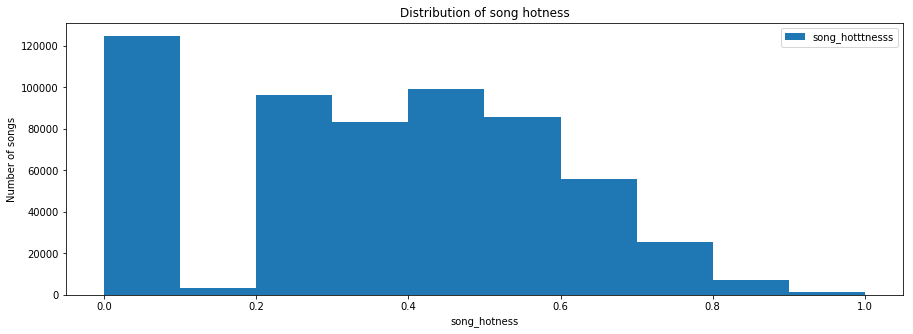

In [76]:
#lets look at the distribution of hotness to categorise hot songs
song_hotness.plot(kind='hist', y='song_hotttnesss', figsize=(15, 5), title='Distribution of song hotness')
plt.ylabel("Number of songs")
plt.xlabel("song_hotness")

In [65]:
song_hotness['song_hotttnesss'].describe()

count    581965.000000
mean          0.356051
std           0.234441
min           0.000000
25%           0.215080
50%           0.377532
75%           0.531985
max           1.000000
Name: song_hotttnesss, dtype: float64

In [77]:
#Assigning top 25% songs with respect to song hotness as a hot song
song_hotness['song_hotttnesss'] = song_hotness['song_hotttnesss']>=0.531985


In [78]:
song_hotness.song_hotttnesss.value_counts()

False    436559
True     145406
Name: song_hotttnesss, dtype: int64

As seen above, total 145406 songs are classified as hot songs

## Lets build our first model that predicts song hotness.

### Classical models

In [68]:
#lets replace all NAs in feature set with 0 
featureset.fillna(0, inplace= True)

In [69]:
#split data into train and test

ratio = 0.7

nrow = np.random.rand(len(featureset)) <= 0.7

X_train = featureset[nrow]
X_test = featureset[~nrow]
y_train = song_hotness[nrow].values.ravel()
y_test = song_hotness[~nrow].values.ravel()

In [70]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score

### Fitting various classical models and plotting their accuracy metrics

Accuracy and AUC (test) for Logistic: 80.7% and 0.76 respectively 
Accuracy and AUC (test) for Naive Bayes: 62.5% and 0.61 respectively 
Accuracy and AUC (test) for Support Vector Classification: 80.7% and 0.76 respectively 
Accuracy and AUC (test) for Random Forest: 81.5% and 0.77 respectively 


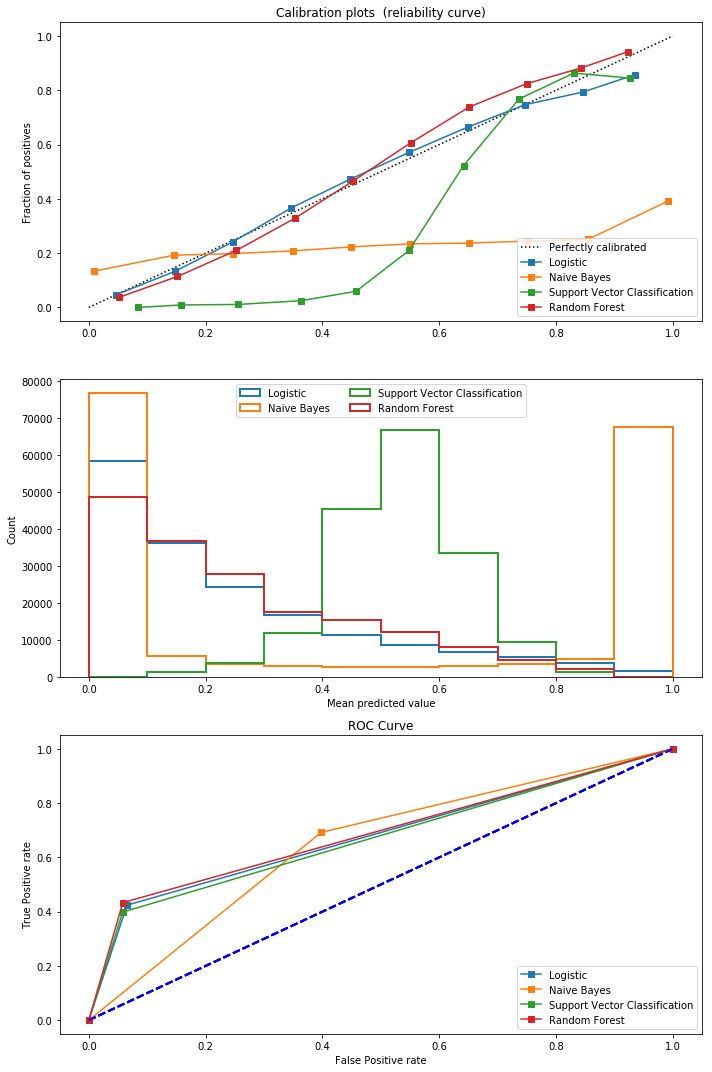

In [71]:
import warnings
warnings.filterwarnings('ignore')
# Create classifiers
lr = LogisticRegression(solver='lbfgs')
gnb = GaussianNB()
svc = LinearSVC(C=1.0)
rfc = RandomForestClassifier(n_estimators=100)


fig, (ax1, ax2, ax3) = plt.subplots(nrows=3,figsize=(10, 15))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(lr, 'Logistic'),
                  (gnb, 'Naive Bayes'),
                  (svc, 'Support Vector Classification'),
                  (rfc, 'Random Forest')]:
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)
        
    # computing accuracy    
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    #computing auc
    auc = roc_auc_score(y_pred,y_test)
    print("Accuracy and AUC (test) for %s: %0.1f%% and %0.2f respectively " % (name, accuracy * 100, auc))
    
    #computing fpr and tpr
    fpr, tpr,_= roc_curve(y_test,y_pred,drop_intermediate=False)
       

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))
    

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)
    
    
    ax3.plot(fpr, tpr, "s-", label="%s" % (name, ))
    ax3.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)


ax3.set_xlabel("False Positive rate")
ax3.set_ylabel("True Positive rate")
ax3.set_ylim([-0.05, 1.05])
ax3.legend(loc="lower right")
ax3.set_title('ROC Curve')

plt.tight_layout()
plt.show()


    

### Random forest seems to be doing good with around 80% accuracy with area under the curve = .77

In [72]:
#lets fit a random forest model and then find features that are important to predict song hotness

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

# computing accuracy    
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

#computing auc
auc = roc_auc_score(y_pred,y_test)
print("Accuracy and AUC (test) for %s: %0.1f%% and %0.2f respectively " % (name, accuracy * 100, auc))


Accuracy and AUC (test) for Random Forest: 81.5% and 0.77 respectively 


### Feature Importance

Text(0.5, 0, 'Relative Importance')

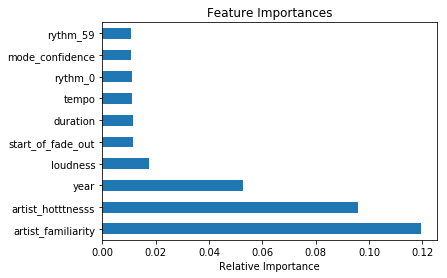

In [79]:
feat_importances = pd.Series(rfc.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importances')
plt.xlabel('Relative Importance')

### Plotting a tree (pending)

In [85]:
msd_subset_path

'D:/Users/rgupta25/Desktop/MSDS/Dataset/millionsongsubset_full/MillionSongSubset/'

In [100]:
from sklearn.tree import export_graphviz
# Export as dot file

rfc_f = rfc.estimators_[99]

export_graphviz(rfc_f, out_file='tree.dot',  feature_names = X_train.columns, class_names = None, rounded = True, proportion = False,   precision = 2, filled = True)



### Artist familiarity, hotness, year, song loudness, genre being pop and rock, and some rythm variables tend to be important features in predicting song hotness

### lets fit a multilayer perceptron to see if it performs better

In [112]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier


Using TensorFlow backend.


In [113]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import tensorflow as tf
from sklearn.metrics import roc_auc_score, confusion_matrix

In [114]:
# Set random seed for reproducibility
seed = 7
np.random.seed(seed)

# Create a baseline model, to see what results we may get

#function for auc


def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)


def create_baseline():
    model = Sequential()
    model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',auroc])
    return model




In [115]:
epochs = 50
batch_size = 256

In [117]:
estimator = KerasClassifier(build_fn=create_baseline, epochs=epochs, batch_size=batch_size, verbose=1)
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("A mean of %.2f%%  with a standard deviation of %.2f%%" % (results.mean()*100, results.std()*100))

Epoch 1/50
271832/271832 [==============================] - 47s 173us/step - loss: 0.4660 - acc: 0.7852 - auroc: 0.7651
Epoch 2/50
271832/271832 [==============================] - 49s 180us/step - loss: 0.4246 - acc: 0.8046 - auroc: 0.8277
Epoch 3/50
271832/271832 [==============================] - 57s 209us/step - loss: 0.4215 - acc: 0.8068 - auroc: 0.8312
Epoch 4/50
271832/271832 [==============================] - 51s 186us/step - loss: 0.4193 - acc: 0.8077 - auroc: 0.8333
Epoch 5/50
271832/271832 [==============================] - 46s 169us/step - loss: 0.4183 - acc: 0.8086 - auroc: 0.8345
Epoch 6/50
271832/271832 [==============================] - 51s 189us/step - loss: 0.4177 - acc: 0.8093 - auroc: 0.8353
Epoch 7/50
271832/271832 [==============================] - 55s 204us/step - loss: 0.4168 - acc: 0.8095 - auroc: 0.8359
Epoch 8/50
271832/271832 [==============================] - 47s 174us/step - loss: 0.4162 - acc: 0.8096 - auroc: 0.8365
Epoch 9/50
271832/271832 [==============

271832/271832 [==============================] - 41s 150us/step - loss: 0.4130 - acc: 0.8124 - auroc: 0.83930s - loss: 0.4129 - acc: 0.8125 - auroc: 
Epoch 17/50
271832/271832 [==============================] - 41s 150us/step - loss: 0.4125 - acc: 0.8126 - auroc: 0.8396
Epoch 18/50
271832/271832 [==============================] - 35s 129us/step - loss: 0.4121 - acc: 0.8128 - auroc: 0.8401
Epoch 19/50
271832/271832 [==============================] - 37s 137us/step - loss: 0.4123 - acc: 0.8126 - auroc: 0.8400
Epoch 20/50
271832/271832 [==============================] - 38s 138us/step - loss: 0.4118 - acc: 0.8130 - auroc: 0.8404
Epoch 21/50
271832/271832 [==============================] - 40s 145us/step - loss: 0.4112 - acc: 0.8131 - auroc: 0.8405
Epoch 22/50
271832/271832 [==============================] - 31s 116us/step - loss: 0.4111 - acc: 0.8130 - auroc: 0.8409
Epoch 23/50
271832/271832 [==============================] - 38s 142us/step - loss: 0.4106 - acc: 0.8139 - auroc: 0.8411
Epo

271832/271832 [==============================] - 40s 149us/step - loss: 0.4063 - acc: 0.8141 - auroc: 0.8443
Epoch 33/50
271832/271832 [==============================] - 43s 158us/step - loss: 0.4061 - acc: 0.8141 - auroc: 0.8445
Epoch 34/50
271832/271832 [==============================] - 40s 148us/step - loss: 0.4058 - acc: 0.8142 - auroc: 0.8445
Epoch 35/50
271832/271832 [==============================] - 37s 138us/step - loss: 0.4054 - acc: 0.8143 - auroc: 0.8449
Epoch 36/50
271832/271832 [==============================] - 40s 147us/step - loss: 0.4052 - acc: 0.8142 - auroc: 0.8455
Epoch 37/50
271832/271832 [==============================] - 37s 135us/step - loss: 0.4050 - acc: 0.8144 - auroc: 0.8455
Epoch 38/50
271832/271832 [==============================] - 2177s 8ms/step - loss: 0.4045 - acc: 0.8150 - auroc: 0.8458
Epoch 39/50
271832/271832 [==============================] - 46s 169us/step - loss: 0.4042 - acc: 0.8147 - auroc: 0.8459
Epoch 40/50
271832/271832 [=================

In [120]:
# Fit the model
lr_model_history  =estimator.fit(X_train, y_train, epochs=10, batch_size=2048, verbose = 1) 
y_pred = estimator.predict(X_test)

Epoch 1/10
407748/407748 [==============================] - 12s 30us/step - loss: 0.5347 - acc: 0.7571 - auroc: 0.6317 
Epoch 2/10
407748/407748 [==============================] - 10s 25us/step - loss: 0.4580 - acc: 0.7863 - auroc: 0.7906
Epoch 3/10
407748/407748 [==============================] - 12s 29us/step - loss: 0.4324 - acc: 0.8009 - auroc: 0.8190
Epoch 4/10
407748/407748 [==============================] - 9s 23us/step - loss: 0.4257 - acc: 0.8046 - auroc: 0.8258
Epoch 5/10
407748/407748 [==============================] - 11s 28us/step - loss: 0.4230 - acc: 0.8061 - auroc: 0.8285 2s - loss: 0.4236 - ac
Epoch 6/10
407748/407748 [==============================] - 12s 30us/step - loss: 0.4212 - acc: 0.8071 - auroc: 0.8303
Epoch 7/10
407748/407748 [==============================] - 11s 28us/step - loss: 0.4200 - acc: 0.8076 - auroc: 0.8317
Epoch 8/10
407748/407748 [==============================] - 11s 27us/step - loss: 0.4189 - acc: 0.8087 - auroc: 0.8328
Epoch 9/10
407748/407748 

In [121]:
print('test data accuracy is ' + str(accuracy_score(y_pred,y_test)) + ' and auc is ' + str(roc_auc_score(y_pred,y_test)))

test data accuracy is 0.8067639782570013 and auc is 0.7659125887603051


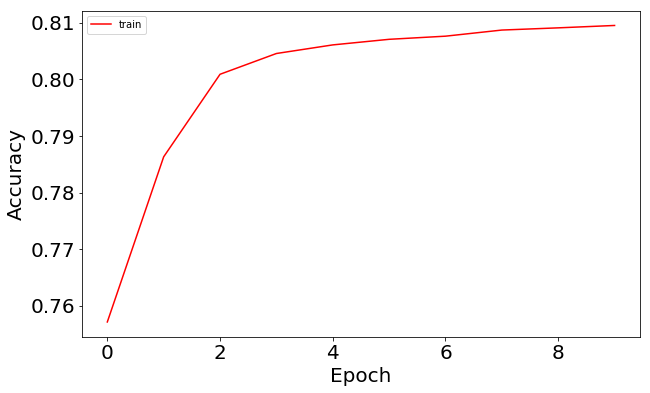

In [122]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot((lr_model_history.history['acc']), 'r', label='train')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

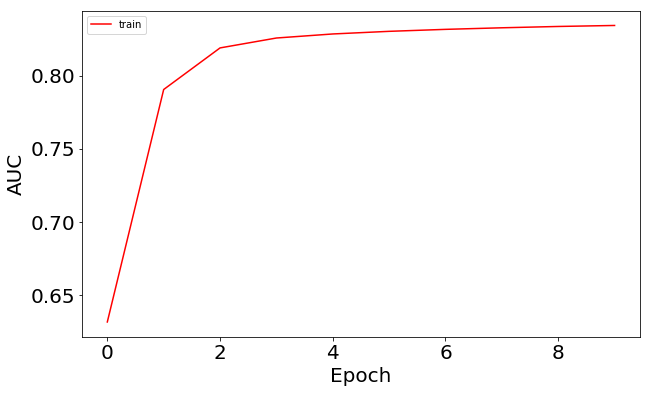

In [123]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot((lr_model_history.history['auroc']), 'r', label='train')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'AUC', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

### MLP provides similar results as RandomForest but RandomForest is still doing better

In [54]:
import psutil
psutil.virtual_memory()

svmem(total=8236412928, available=177827840, percent=97.8, used=8058585088, free=177827840)

# Lets load lyrics data

### Download data from this path and place database in your local data folder

http://labrosa.ee.columbia.edu/millionsong/sites/default/files/AdditionalFiles/mxm_dataset.db

In [55]:
#parsing the sql database for the lyrics data
import sqlite3
con = sqlite3.connect(msd_subset_path+ '/musixmatch/mxm_dataset.db')
words = pd.read_sql(sql = 'SELECT * FROM words', con = con)
lyrics_0 = pd.read_sql(sql = 'SELECT * FROM lyrics', con = con)
con.close()


In [56]:
print('shape of words is: ' + str(words.shape))
print('shape of lyrics is: ' + str(lyrics_0.shape))

shape of words is: (5000, 1)
shape of lyrics is: (19045332, 5)


In [57]:
lyrics_0.head()

,track_id,mxm_tid,word,count,is_test
0,TRAAAAV128F421A322,4623710,i,6,0
1,TRAAAAV128F421A322,4623710,the,4,0
2,TRAAAAV128F421A322,4623710,you,2,0
3,TRAAAAV128F421A322,4623710,to,2,0
4,TRAAAAV128F421A322,4623710,and,5,0


### Lets remove stop words

In [58]:
from string import punctuation
import nltk
nltk.download('stopwords')
stop = stopwords.words('english') +list(punctuation)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rgupta25\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [59]:
len(stop)

211

In [60]:
#finding small words in lyrics data
small_words = [i for i in words.word if len(i)<=2]
len(small_words)

244

In [61]:
#adding small words in stop words
stop = stop + list(small_words)
len(stop)

455

In [62]:
del con,words

In [63]:
#Dropping stop words and very short words from lyrics data
lyrics_1 = lyrics_0[~lyrics_0.word.isin(stop)]


In [64]:
lyrics_1.head()

,track_id,mxm_tid,word,count,is_test
22,TRAAAAV128F421A322,4623710,like,2,0
27,TRAAAAV128F421A322,4623710,got,1,0
28,TRAAAAV128F421A322,4623710,would,1,0
31,TRAAAAV128F421A322,4623710,seem,1,0
32,TRAAAAV128F421A322,4623710,someon,1,0


In [65]:
lyrics_1.word.nunique()

4674

In [66]:
lyrics_1.track_id.nunique()

237490

In [67]:
#keeping only those tracks in lyrics data that are available in fullset_augmented set
#data = fullset_augmented.dropna(subset = ['song_hotttnesss'])
tracks_lyrics = set(lyrics_0.track_id)

In [68]:
#lets check how many songs are captured in lyrics data from main fullset
fullset_augmented_lyrics = fullset_augmented[fullset_augmented.track_id.isin(tracks_lyrics)]
#lets remove the null song hotness
fullset_augmented_lyrics.dropna(subset = ['song_hotttnesss'], inplace = True)
#lyrics_1 = pd.merge(fullset_augmented, lyrics_1[['track_id']] , on = 'track_id', how = 'inner')
fullset_augmented_lyrics.track_id.nunique()

C:\ProgramData\Anaconda2\envs\py360\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


170573

In [69]:
tracks_fullset_hotness = set(fullset_augmented_lyrics.track_id)

In [70]:
len(tracks_fullset_hotness)

170573

In [71]:
fullset_augmented_lyrics.shape

(170573, 89)

### Only 170573 songs have lyrics data from a million songs dataset of MSD with available song hotness

In [72]:
#lets check the distribution of song hotness for the tracks available in lyrics data
song_hotness_lyrics = fullset_augmented_lyrics[['track_id','song_hotttnesss']].drop_duplicates()

Text(0.5, 0, 'song_hotness')

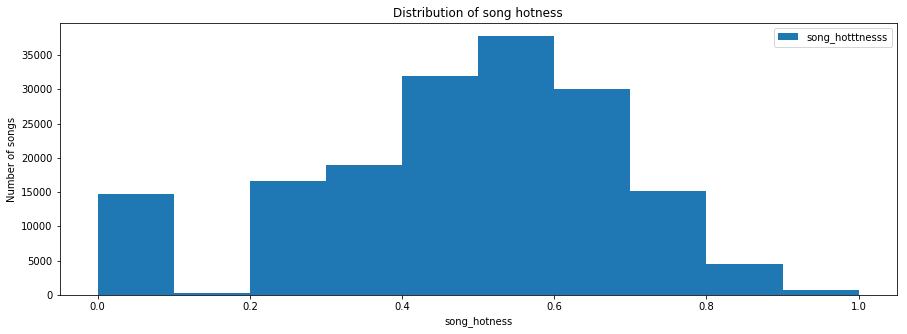

In [73]:
song_hotness_lyrics.plot(kind='hist', y='song_hotttnesss', figsize=(15, 5), title='Distribution of song hotness')
plt.ylabel("Number of songs")
plt.xlabel("song_hotness")

### the words in lyrics data are stemmed versions of the original words. We can replace them with the original words to make better sense. The data for unstemmed words can be downloaded from http://labrosa.ee.columbia.edu/millionsong/sites/default/files/mxm_reverse_mapping.txt

In [74]:
#Replacing the tokens with unstemmed versions for better comprehension
unstem = pd.read_csv(msd_subset_path + '/musixmatch/mxm_reverse_mapping.txt', sep = '<SEP>', names = ['original','unstemmed'])

C:\ProgramData\Anaconda2\envs\py360\lib\site-packages\ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [75]:
len(unstem)

5000

In [76]:
unstem.head(10)

,original,unstemmed
0,dÃ­a,dÃ­a
1,pido,pido
2,hatr,hatred
3,pide,pide
4,yellow,yellow
5,four,four
6,sleev,sleeve
7,sleep,sleep
8,thirst,thirst
9,upsid,upside


In [77]:
unstem.columns = ['word', 'unstemmed_word']

In [78]:
unstem.head(10)

,word,unstemmed_word
0,dÃ­a,dÃ­a
1,pido,pido
2,hatr,hatred
3,pide,pide
4,yellow,yellow
5,four,four
6,sleev,sleeve
7,sleep,sleep
8,thirst,thirst
9,upsid,upside


In [79]:
#merging stemmed words in lyrics data with their unstemmed versions
lyrics_2 = pd.merge(lyrics_1, unstem, on = 'word', how = 'left')

In [112]:
lyrics_2.head()

,track_id,mxm_tid,count,is_test,word
0,TRAAAAV128F421A322,4623710,2,0,like
1,TRAAAAV128F421A322,4623710,1,0,got
2,TRAAAAV128F421A322,4623710,1,0,would
3,TRAAAAV128F421A322,4623710,1,0,seems
4,TRAAAAV128F421A322,4623710,1,0,someone


In [81]:
#dropping word column and rename unstemmed_word with word
lyrics_2.drop('word', axis = 1, inplace = True)
lyrics_2.rename(columns={'unstemmed_word':'word'}, inplace=True)
lyrics_2.head()

,track_id,mxm_tid,count,is_test,word
0,TRAAAAV128F421A322,4623710,2,0,like
1,TRAAAAV128F421A322,4623710,1,0,got
2,TRAAAAV128F421A322,4623710,1,0,would
3,TRAAAAV128F421A322,4623710,1,0,seems
4,TRAAAAV128F421A322,4623710,1,0,someone


In [82]:
#total tracks in lyrics data
print('total tracks in lyrics data are: ' + str(lyrics_2.track_id.nunique()))

#using those tracks from lyrics data that are in subset
tracks_msd = set(fullset_augmented.track_id)
lyrics_2_sub = lyrics_2[lyrics_2.track_id.isin(tracks_msd)]
print('total tracks from lyrics data in subset are: ' + str( lyrics_2_sub.track_id.nunique()))                                        
                                         

total tracks in lyrics data are: 237490
total tracks from lyrics data in subset are: 237490


In [83]:
#removing nans from lyrics data
lyrics_2_sub.shape

(12012735, 5)

In [84]:
lyrics_2_sub = lyrics_2_sub[~lyrics_2_sub.word.isna()]
lyrics_2_sub = lyrics_2_sub[lyrics_2_sub.track_id.isin(tracks_fullset_hotness)]

In [85]:
lyrics_2_sub.shape

(8605757, 5)

In [86]:
lyrics_2_sub.track_id.nunique()

170446

In [90]:
tracks_lyrics_hotness = set(lyrics_2_sub.track_id)

In [91]:
import random

tracks_lyrics_hotnes_sample = random.sample(tracks_lyrics_hotness,25000)

In [92]:
len(tracks_lyrics_hotnes_sample)

25000

In [93]:
lyrics_2_sample = lyrics_2_sub[lyrics_2_sub.track_id.isin(tracks_lyrics_hotnes_sample)]

In [94]:
lyrics_2_sample.shape

(1257302, 5)

In [95]:
lyrics_2_sample.track_id.nunique()

25000

In [96]:
#Getting rid of columns I don't need
lyrics_3 = lyrics_2_sample[['track_id','word','count']]

#Converting the melted dataframe into a pivot table that will serve as my vectorized dataset
lyrics = pd.pivot_table(lyrics_3[['track_id','word','count']], values = 'count', index = 'track_id', columns = ['word'])

In [97]:
lyrics.shape

(25000, 4537)

In [98]:
#Filling in 0s
lyrics = lyrics.replace(to_replace=np.NaN, value = 0)


### Setting up LDA to find important topics

In [99]:
#Setting up the format to use the gensim modeling library
lyrics_text = [lyrics.columns[lyrics.loc[index,:].nonzero()] for index in lyrics.index]
dictionary = Dictionary(lyrics_text)
corpus_plot = [dictionary.doc2bow(text) for text in lyrics_text]

C:\ProgramData\Anaconda2\envs\py360\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  


In [100]:
#Function to run an LDA and do a coherance model on it to find the best value of number of topics
from gensim.models.coherencemodel import CoherenceModel

def coherence_search(dictionary, corpus_dict, text, upper_limit, start, step):
    coherence_score = []
    model_list = []
    for num_topics in range(start, upper_limit, step):
        fun_model=models.ldamulticore.LdaMulticore(corpus=corpus_dict, 
                           id2word=dictionary, 
                           num_topics=num_topics,
                           passes = 5,
                           minimum_probability = 0.01)
        model_list.append(fun_model)
        coherencem = CoherenceModel(model=fun_model, texts=text, dictionary=dictionary, coherence='c_v', processes = 15)
        coherence_score.append(coherencem.get_coherence())

    return model_list, coherence_score

**Running the function and getting our LDA**

In [101]:
#Runnin function above for lyrics set
%timeit
search = coherence_search(dictionary=dictionary,corpus_dict=corpus_plot,text = lyrics_text, upper_limit= 100, start = 5, step = 5)

C:\ProgramData\Anaconda2\envs\py360\lib\site-packages\gensim\models\ldamodel.py:775: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


### Plotting Coherance to find best number of topics to cluster over

In [102]:
model_result = search[0]
scores = search[1]

Text(0, 0.5, 'coherence score')

<Figure size 864x720 with 0 Axes>

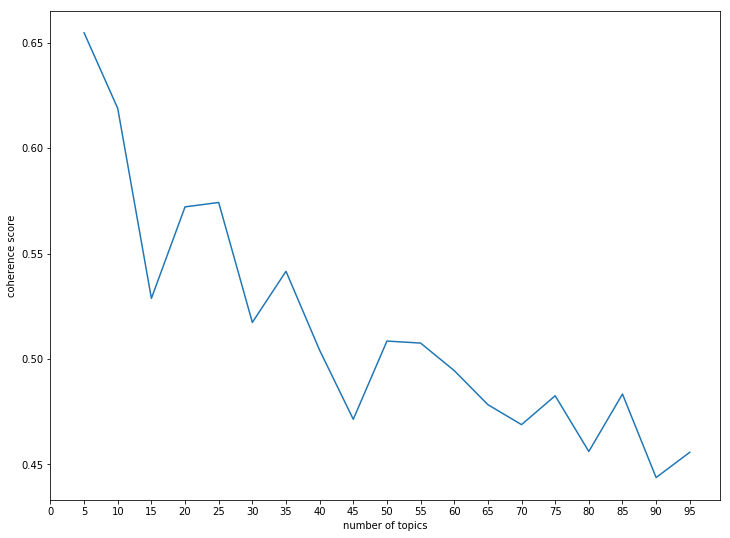

In [103]:
fig = plt.figure(figsize=(12, 10));
plt.figure(figsize=(12,9));
plt.plot(range(5,100,5),scores);
plt.xticks(np.arange(0,100, step =5),list(range(0,100,5)));
plt.xlabel('number of topics')
plt.ylabel('coherence score')

### optimal number of topics seem to be 5.

In [107]:
#fitting coherence model for 15 topics
#A singular model initializer if the wait for the coherence model above is inconvenient
final_model=models.ldamulticore.LdaMulticore(corpus=corpus_plot, 
                           id2word=dictionary, 
                           num_topics=5,
                           passes = 5,
                           minimum_probability = 0.01)

In [108]:
#Creating a matrix of the different topics and the probabilities for top 100 tokens
topic_matrix = pd.DataFrame(final_model.get_topics())

topic_matrix

words = list(lyrics.columns)

topic_words = [[words[i[0]] for i in final_model.get_topic_terms(j, topn = 100)] for j in range(final_model.num_topics)]

In [109]:
df_topics = pd.DataFrame(topic_words).T
df_topics.columns= [i for i in range(1,6)]
df_topics.index = range(1,101)
#df_topics.to_csv('./csv_subset/topics.csv')
df_topics

,1,2,3,4,5
1,bullet,bark,alegre,aussi,acaba
2,beans,bleed,awake,evidence,ace
3,alegre,borrow,advice,askin',advice
4,acaba,blir,apart,escucha,amongst
5,alegria,born,andar,ask,apart
6,afraid,bord,anticipating,lucky,ahora
7,amongst,blaze,acaba,every,bold
8,add,bowl,ace,esperar,ahhh
9,'bout,drugs,best,estar,alegre
10,ace,blink,afford,eres,amazing


### Top topics and their probabilities

In [110]:
top_words = [[word for word,_ in final_model.show_topic(topicno, topn=50)] for topicno in range(final_model.num_topics)]
top_betas = [[beta for _,beta in final_model.show_topic(topicno, topn=50)] for topicno in range(final_model.num_topics)]
print("Top Topics:")
for topicno, words in enumerate(top_words):
    print("%i: %s" % (topicno, ' '.join(words[:10])))
print("Top Topic Betas:")
for topicno, betas in enumerate(top_betas):
    print("%i: %s" % (topicno, ' '.join(map(str,betas[:10]))))

Top Topics:
0: got get know like make yeah come say 'cause one
1: que por con una como amor para los est todo
2: know love time see feel never like one way would
3: die und der das den ich nicht ein ist auf
4: like one time come see eyes life day know back
Top Topic Betas:
0: 0.010144045 0.009920171 0.009111812 0.008207743 0.006281991 0.0059635933 0.005881616 0.005857761 0.0058042007 0.0057820915
1: 0.01978689 0.008966483 0.008607617 0.00785516 0.007060238 0.006982857 0.0066264374 0.006368501 0.0058778217 0.00581503
2: 0.012805096 0.01169606 0.009915229 0.009183037 0.009049711 0.008904388 0.008350081 0.008200441 0.007848333 0.0075679915
3: 0.01711094 0.016501572 0.014772492 0.014098544 0.014015049 0.013944797 0.013810845 0.013676486 0.012583014 0.010607301
4: 0.0060450886 0.005497489 0.0051196963 0.0051062247 0.0047708387 0.0040668757 0.004031806 0.003905129 0.003747992 0.0037376124


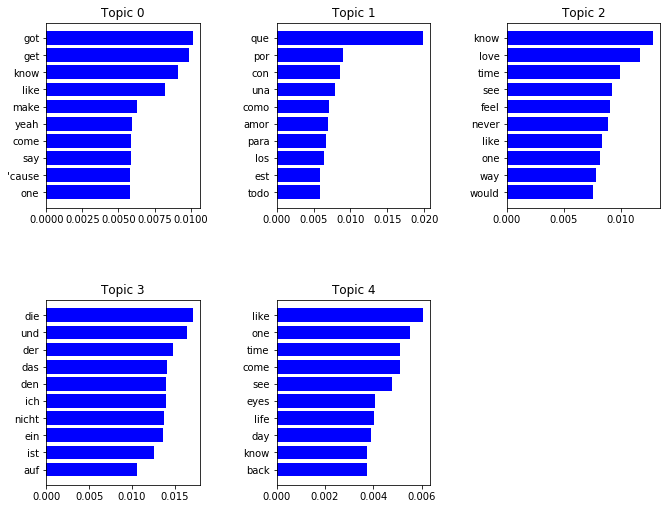

In [114]:
#plotting horizontal bar charts
from matplotlib import gridspec
top_words[0][:5]
top_betas[0][:5]
gs  = gridspec.GridSpec(2,3)
gs.update(wspace=0.5, hspace=0.5)
plt.figure(figsize=(11,8.5))
for i in range(5):
    #new subplot
    ax = plt.subplot(gs[i])
    plt.barh(range(10), top_betas[i][:10], align='center',color='blue', ecolor='black')
    ax.invert_yaxis()
    ax.set_yticks(range(10))
    ax.set_yticklabels(top_words[i][:10])
    plt.title("Topic "+str(i))
_ = plt.show()

### Wordclouds of lyrics data

(-0.5, 399.5, 199.5, -0.5)

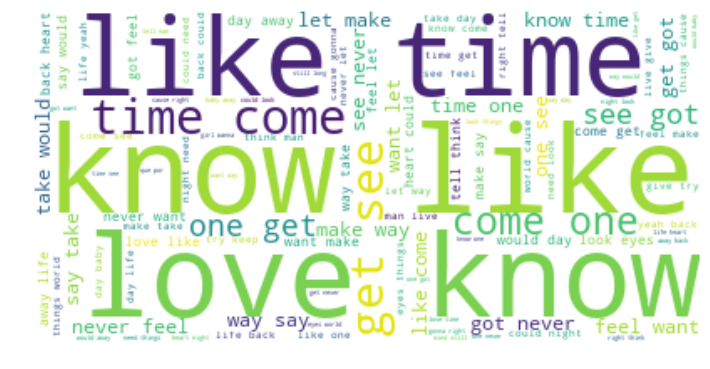

In [124]:
from os import path
from PIL import Image

from wordcloud import WordCloud, STOPWORDS

# Read the whole text.
t = list(lyrics_2_sample['word'])
text_cloud = ' '.join(t)

# read the mask image
# https://banner2.kisspng.com/20180308/eiq/kisspng-musical-note-graphic-design-flying-notes-5aa11bbb905150.6488331115205078355911.jpg
#music_mask = np.array(Image.open(msd_subset_path + '/musixmatch/music.jpg' ))

wc = WordCloud(background_color="white", max_words=100,
               stopwords=stop, contour_width=3, contour_color='steelblue')

# generate word cloud
wc.generate(text_cloud)

# store to file
#wc.to_file('./wordclouds/words.png')

# show
plt.figure(figsize=(12, 10))
plt.imshow(wc, interpolation='bilinear');
plt.axis("off")

#plt.imshow(music_mask, cmap=plt.cm.gist_rainbow, interpolation='bilinear');
plt.axis("off")


### plotting wordclouds for each topic

C:\ProgramData\Anaconda2\envs\py360\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
C:\ProgramData\Anaconda2\envs\py360\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
C:\ProgramData\Anaconda2\envs\py360\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
C:\ProgramData\Anaconda2\envs\py360\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("

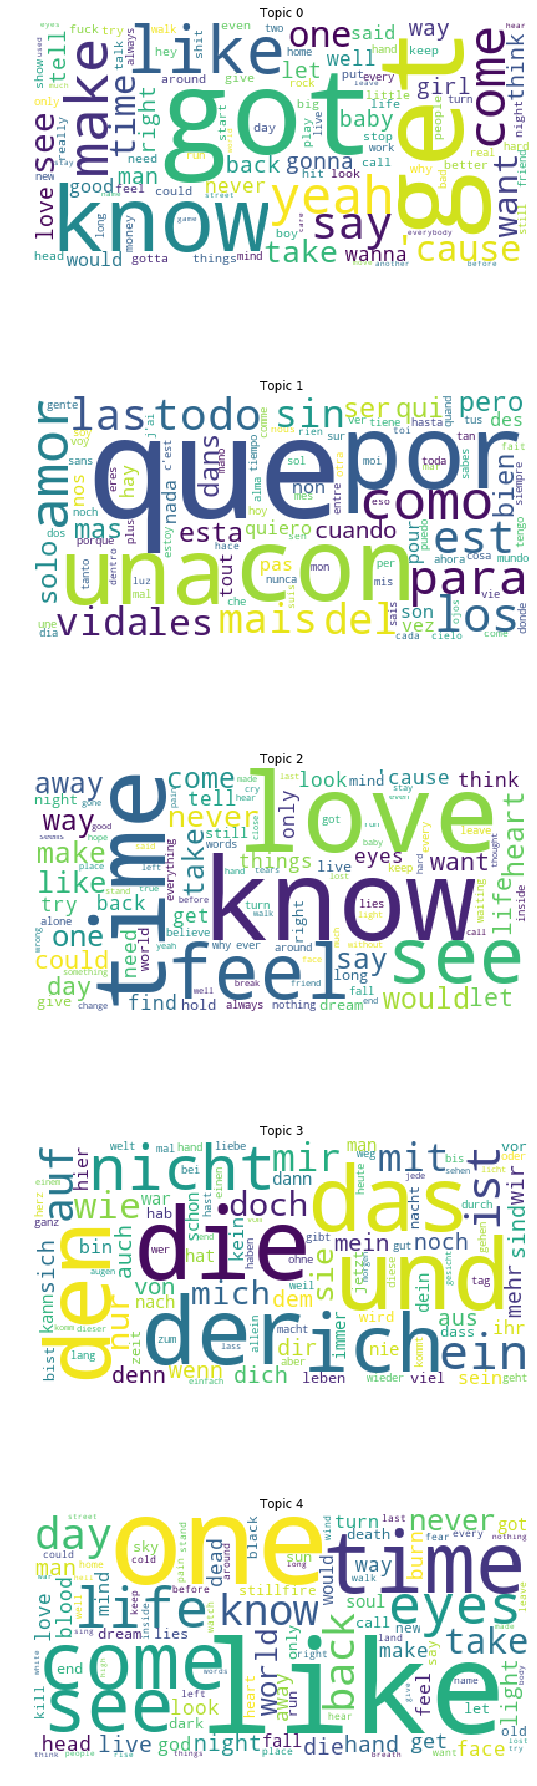

In [125]:
#plotting word cloud for each topic
gs  = gridspec.GridSpec(5,1)
gs.update(wspace=0.5, hspace=0.5)
plt.figure(figsize=(16,32))
for i in range(final_model.num_topics):
    #new subplot
    ax = plt.subplot(gs[i])
    plt.imshow(WordCloud(background_color="white", max_words=100,stopwords=stop, contour_width=3, contour_color='steelblue').fit_words(dict(final_model.show_topic(i, 200))))
    #ax.invert_yaxis()
    ax.axis("off")
    plt.title("Topic "+str(i))
    plt.tight_layout()
_ = plt.show()

### Assigning Topics to Songs

> *Utlizing* ***[Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity)*** *which utilizes the definition of similairy through the relationship between the dot product of 2 vectors and cosine:*
![cosine sim formula](https://wikimedia.org/api/rest_v1/media/math/render/svg/1d94e5903f7936d3c131e040ef2c51b473dd071d)

In [126]:
#Calculates the cosine similarity between 2 lists of strings
def cosine_sim(a,b):
    from collections import Counter

    # count word occurrences
    a_vals = Counter(a)
    b_vals = Counter(b)

    # convert to word-vectors
    words  = list(a_vals.keys() | b_vals.keys())
    a_vect = [a_vals.get(word, 0) for word in words]        
    b_vect = [b_vals.get(word, 0) for word in words]        

    # find cosine
    len_a  = sum(av*av for av in a_vect) ** 0.5             
    len_b  = sum(bv*bv for bv in b_vect) ** 0.5             
    dot_product = sum(av*bv for av,bv in zip(a_vect, b_vect))    
    cosine_similarity = dot_product / (len_a * len_b)                          
    
    return cosine_similarity

In [127]:
#demo of the function
cosine_sim(['This', 'is', 'a', 'test', 'list', 'with', 'extra', 'words'],['This', 'is', 'a', 'test', 'list'])

0.7905694150420948

In [129]:
score_matrix = []
for name in lyrics.index:
    scores = []
    word_index = np.nonzero(lyrics.loc[name])
    word_list = tuple([lyrics.columns[i] for i in word_index][0])
    for topic in topic_words:
        try:
            score = cosine_sim(list(word_list),topic)
            scores.append(score)
        except:
            pass
    score_matrix.append(scores)
        

df_cos = pd.DataFrame(score_matrix, columns=['Topic 1','Topic 2','Topic 3','Topic 4','Topic 5'], index=lyrics.index)


In [130]:
df_cos.shape

(25000, 5)

In [131]:
df_cos.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
track_id,,,,,
TRAAARJ128F9320760,0.040825,0.013608,0.040825,0.000000,0.040825
TRAABHC128F933A3F8,0.024434,0.036651,0.036651,0.024434,0.036651
TRAACER128F4290F96,0.021953,0.021953,0.043906,0.010976,0.032929
TRAADLH12903CA70EE,0.000000,0.020851,0.000000,0.020851,0.000000
TRAAFRM128F9320F58,0.000000,0.000000,0.000000,0.044721,0.000000


In [132]:
df_cos1 = df_cos.apply(lambda x: x == x.max(), axis=1).astype(int) 

In [133]:
df_cos1.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
track_id,,,,,
TRAAARJ128F9320760,1,0,1,0,1
TRAABHC128F933A3F8,0,1,1,0,1
TRAACER128F4290F96,0,0,1,0,0
TRAADLH12903CA70EE,0,1,0,1,0
TRAAFRM128F9320F58,0,0,0,1,0


### Lets use topics information ONLY to predict song hotness

In [135]:
print('Shape of topics data: ' + str(df_cos1.shape))

#getting song hotness only for tracks that are available in topics data

df_lyrics_subset = pd.merge(df_cos1,fullset_augmented[['track_id','song_hotttnesss']], on = 'track_id', how = 'inner')


Shape of topics data: (25000, 5)


In [136]:
df_lyrics_subset.head()

,track_id,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,song_hotttnesss
0,TRAAARJ128F9320760,1,0,1,0,1,0.265861
1,TRAABHC128F933A3F8,0,1,1,0,1,0.192736
2,TRAACER128F4290F96,0,0,1,0,0,0.666528
3,TRAADLH12903CA70EE,0,1,0,1,0,0.528782
4,TRAAFRM128F9320F58,0,0,0,1,0,0.413740


In [137]:
#dropping rows with missing song hotness
data = df_lyrics_subset.dropna(subset = ['song_hotttnesss'])
print('Shape of dataframe after removing missing song hotness: ' + str(data.shape))


#selecting numeric columns
data_num = data._get_numeric_data()
print('Shape of dataframe after selecting numeric columns: ' + str(data_num.shape))


#assigning song hotness to a target while dropping it from featureset
song_hotness = data_num[['song_hotttnesss']]
data_num = data_num.drop(columns = 'song_hotttnesss')                                     


featureset = data_num

print('Shape of featureset: ' + str(featureset.shape) + ' and shape of target: '+ str(song_hotness.shape))


Shape of dataframe after removing missing song hotness: (25000, 7)
Shape of dataframe after selecting numeric columns: (25000, 6)
Shape of featureset: (25000, 5) and shape of target: (25000, 1)


In [138]:
featureset.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,1,0,1,0,1
1,0,1,1,0,1
2,0,0,1,0,0
3,0,1,0,1,0
4,0,0,0,1,0


In [139]:
#Assigning top 25% songs with respect to song hotness as a hot song
song_hotness['song_hotttnesss'] = song_hotness['song_hotttnesss']>=0.537504


In [140]:
song_hotness.song_hotttnesss.value_counts()

False    14110
True     10890
Name: song_hotttnesss, dtype: int64

As seen above, total 761 songs are classified as hot songs in lyrics data

### Classical models

In [141]:
#lets replace all NAs in feature set with 0 
featureset.fillna(0, inplace= True)

In [142]:
#split data into train and test

ratio = 0.7

nrow = np.random.rand(len(featureset)) <= 0.7

X_train = featureset[nrow]
X_test = featureset[~nrow]
y_train = song_hotness[nrow].values.ravel()
y_test = song_hotness[~nrow].values.ravel()

In [143]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score

### Fitting various classical models and plotting their accuracy metrics

Accuracy and AUC (test) for Logistic: 56.7% and 0.00 respectively 
Accuracy and AUC (test) for Naive Bayes: 56.7% and 0.00 respectively 
Accuracy and AUC (test) for Support Vector Classification: 56.7% and 0.00 respectively 
Accuracy and AUC (test) for Random Forest: 56.7% and 0.00 respectively 


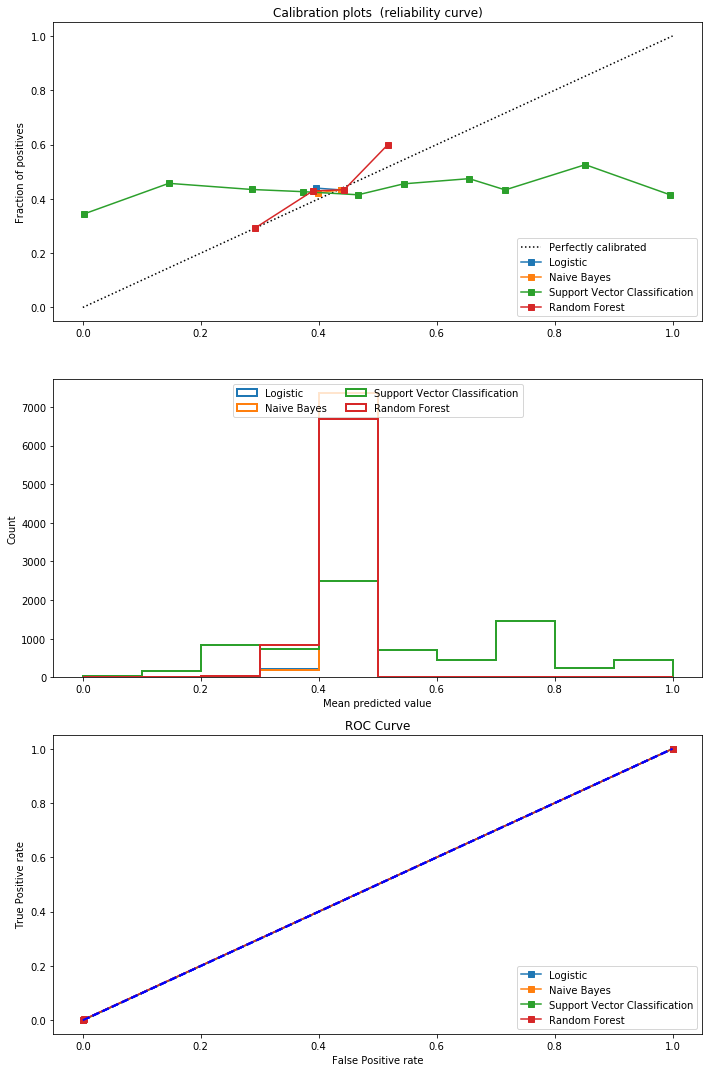

In [155]:
import warnings
warnings.filterwarnings('ignore')
# Create classifiers
lr = LogisticRegression(solver='lbfgs')
gnb = GaussianNB()
svc = LinearSVC(C=1.0)
rfc = RandomForestClassifier(n_estimators=100)


fig, (ax1, ax2, ax3) = plt.subplots(nrows=3,figsize=(10, 15))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(lr, 'Logistic'),
                  (gnb, 'Naive Bayes'),
                  (svc, 'Support Vector Classification'),
                  (rfc, 'Random Forest')]:
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)
        
    # computing accuracy    
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    #computing auc
    #auc = roc_auc_score(y_pred,y_test)
    auc = 0
    print("Accuracy and AUC (test) for %s: %0.1f%% and %0.2f respectively " % (name, accuracy * 100, auc))
    
    #computing fpr and tpr
    fpr, tpr,_= roc_curve(y_test,y_pred,drop_intermediate=False)
       

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))
    

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)
    
    
    ax3.plot(fpr, tpr, "s-", label="%s" % (name, ))
    ax3.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)


ax3.set_xlabel("False Positive rate")
ax3.set_ylabel("True Positive rate")
ax3.set_ylim([-0.05, 1.05])
ax3.legend(loc="lower right")
ax3.set_title('ROC Curve')

plt.tight_layout()
plt.show()


    

### As shown above, topics on their own dont have much impact on song hotness. Lets see if topics information in addition to other information about songs lead to better accuracy

### Lets use all information from augmented subset and topics information from lyrics data to predict song hotness

In [184]:
from sklearn.preprocessing import MinMaxScaler


print('Total columns in augmented data: ' + str(fullset_augmented.shape[1]))

#merging topics with augmented data

df_lyrics_subset = pd.merge(df_cos1,fullset_augmented, on = 'track_id', how = 'inner')
print('Shape of dataframe after adding topics: ' + str(df_lyrics_subset.shape))


#dropping rows with missing song hotness
data = df_lyrics_subset.dropna(subset = ['song_hotttnesss'])
print('Shape of dataframe after removing missing song hotness: ' + str(data.shape))


#selecting numeric columns
data_num = data._get_numeric_data()
print('Shape of dataframe after selecting numeric columns: ' + str(data_num.shape))


#dropping danceability and energy and digital id 
cols_to_drop = ['danceability', 'energy','genre','analysis_sample_rate']
data_num = data_num.drop(columns = cols_to_drop)
print('Shape of dataframe after deleting ids and other useless numeric columns: ' + str(data_num.shape))

#assigning song hotness to a target while dropping it from featureset
song_hotness = data_num[['song_hotttnesss']]
data_num = data_num.drop(columns = 'song_hotttnesss')                               
          
                
#scaling numeric columns
scaler = MinMaxScaler() 
data_num_scaled = pd.DataFrame(scaler.fit_transform(data_num.values),columns = data_num.columns)


#adding useful string columns genre and style and add one hot encoded features for the same

cols_to_encode = ['genre_id', 'style_id']
string_encoded_features = pd.get_dummies(data[cols_to_encode], prefix=['genre', 'style']).reset_index(drop = True)
featureset = pd.concat([data_num_scaled, string_encoded_features],axis = 1)


print('Shape of dataframe after adding encoded features for string columns: ' + str(featureset.shape))

print('Shape of featureset: ' + str(featureset.shape) + ' and shape of target: '+ str(song_hotness.shape))


Total columns in augmented data: 89
Shape of dataframe after adding topics: (25000, 94)
Shape of dataframe after removing missing song hotness: (25000, 94)
Shape of dataframe after selecting numeric columns: (25000, 84)
Shape of dataframe after deleting ids and other useless numeric columns: (25000, 80)
Shape of dataframe after adding encoded features for string columns: (25000, 125)
Shape of featureset: (25000, 125) and shape of target: (25000, 1)


In [185]:
#lets replace all NAs in feature set with 0 
featureset.fillna(0, inplace= True)

In [186]:
song_hotness['song_hotttnesss'].describe()

count    25000.000000
mean         0.476244
std          0.210443
min          0.000000
25%          0.367273
50%          0.509641
75%          0.621583
max          1.000000
Name: song_hotttnesss, dtype: float64

In [187]:
#Assigning top 25% songs with respect to song hotness as a hot song
song_hotness['song_hotttnesss'] = song_hotness['song_hotttnesss']>=0.62158


In [188]:
song_hotness.song_hotttnesss.value_counts()

False    18749
True      6251
Name: song_hotttnesss, dtype: int64

In [189]:
#split data into train and test

ratio = 0.7

nrow = np.random.rand(len(featureset)) <= 0.7

X_train = featureset[nrow]
X_test = featureset[~nrow]
y_train = song_hotness[nrow].values.ravel()
y_test = song_hotness[~nrow].values.ravel()

### Fitting various classical models and plotting their accuracy metrics

Accuracy and AUC (test) for Logistic: 78.7% and 0.72 respectively 
Accuracy and AUC (test) for Naive Bayes: 44.7% and 0.59 respectively 
Accuracy and AUC (test) for Support Vector Classification: 78.6% and 0.72 respectively 
Accuracy and AUC (test) for Random Forest: 78.7% and 0.73 respectively 


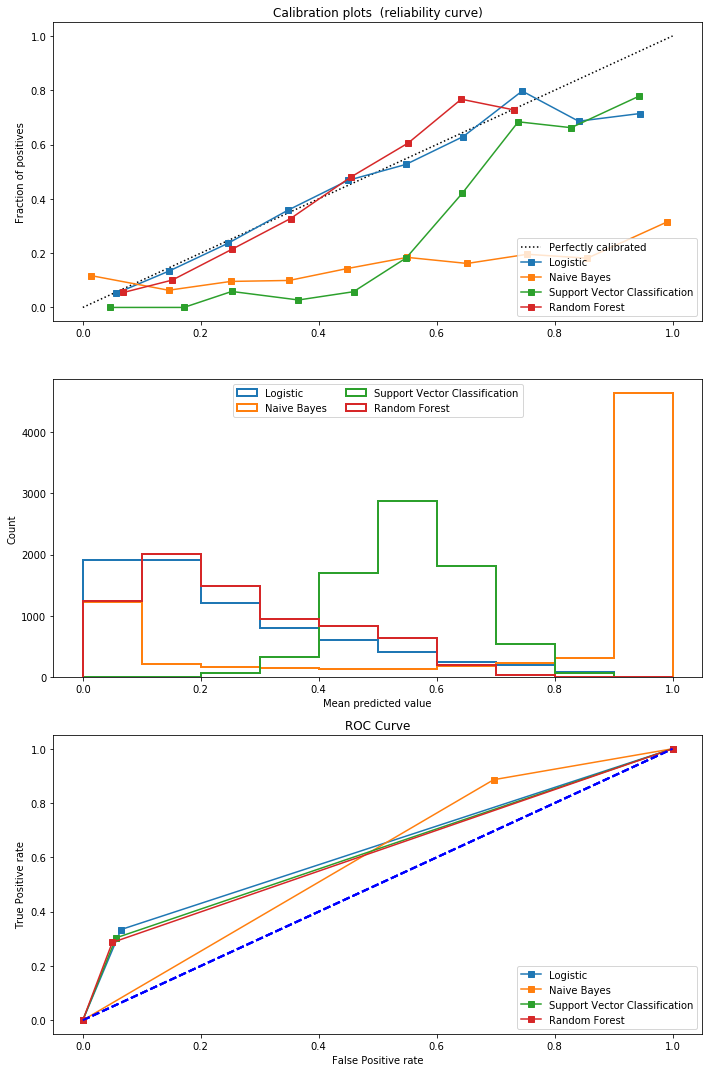

In [190]:
import warnings
warnings.filterwarnings('ignore')
# Create classifiers
lr = LogisticRegression(solver='lbfgs')
gnb = GaussianNB()
svc = LinearSVC(C=1.0)
rfc = RandomForestClassifier(n_estimators=100)


fig, (ax1, ax2, ax3) = plt.subplots(nrows=3,figsize=(10, 15))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(lr, 'Logistic'),
                  (gnb, 'Naive Bayes'),
                  (svc, 'Support Vector Classification'),
                  (rfc, 'Random Forest')]:
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)
        
    # computing accuracy    
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    #computing auc
    auc = roc_auc_score(y_pred,y_test)
    print("Accuracy and AUC (test) for %s: %0.1f%% and %0.2f respectively " % (name, accuracy * 100, auc))
    
    #computing fpr and tpr
    fpr, tpr,_= roc_curve(y_test,y_pred,drop_intermediate=False)
       

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))
    

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)
    
    
    ax3.plot(fpr, tpr, "s-", label="%s" % (name, ))
    ax3.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)


ax3.set_xlabel("False Positive rate")
ax3.set_ylabel("True Positive rate")
ax3.set_ylim([-0.05, 1.05])
ax3.legend(loc="lower right")
ax3.set_title('ROC Curve')

plt.tight_layout()
plt.show()


    

In [191]:
#lets fit a random forest model and then find features that are important to predict song hotness

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

# computing accuracy    
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

#computing auc
auc = roc_auc_score(y_pred,y_test)
print("Accuracy and AUC (test) for %s: %0.1f%% and %0.2f respectively " % (name, accuracy * 100, auc))


Accuracy and AUC (test) for Random Forest: 78.7% and 0.73 respectively 


Text(0.5, 0, 'Relative Importance')

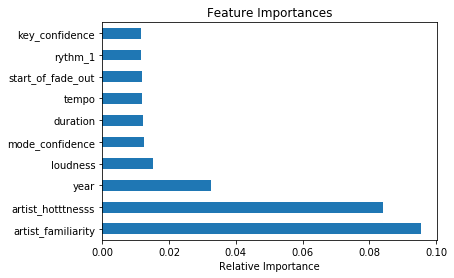

In [192]:
feat_importances = pd.Series(rfc.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importances')
plt.xlabel('Relative Importance')

### The accuracy based on lyrics subset data actually got lower probably because data was a sample of 25000 songs so it may not have been representative of entire fullset and secondly additional features related to lyrics may have been completely redundant using which led to a lower accuracy when training a model with these features

## Findings:

- Artist familiarity and hotness, along with song loudness, tempo and few rythm variables seem to be a good predictor of song hotness
- Classical models as well as MLP did equally well to predict song hotness. Random Forest perfored the best with close to 80% accuracy and auc = 0.8.
- Lyrics were analysed for the songs from the subset for which it was available
- Applied LDA to categorise lyrics into 15 topics. Word clouds for these topics found that words like 'Love', 'Heart', 'Like', 'Time' were important words.
- The topics generated in this way was used to predict song hotness. We noticed that topics do not have an impact on song hotness.

# Investigate numerical arrays

Several of the columns include lists of numbers, which are explored further in this section. 

The dataset contains numerical information in the form of arrays for distinct parts of each song:

1. __Bars__:  A bar (or measure) is a segment of time defined as a given number of beats. 

2. __Beats__:  A beat is the basic time unit of a piece of music; for example, each tick of a metronome. Beats are typically multiples of tatums.

3. __Sections__: Sections are defined by large variations in rhythm or timbre, e.g. chorus, verse, bridge, guitar solo, etc.

4. __Segments__: A set of sound entities (typically under a second) each relatively uniform in timbre and harmony. 

5. __Tatums__: Tatums represent the lowest regular pulse train that a listener intuitively infers from the timing of perceived musical events (segments). 

All of these parts have two columns associated with them:

* __Start:__ the markers explained above, in seconds.

* __Confidence:__ Confidence indicates the reliability of its corresponding attribute. Elements carrying a small confidence value should be considered speculative. 

The most detailed information is for segments, which contain several other features:
* __Loudness_max__: peak loudness value within the segment
* __Loudness_max_time__: offset within the segment of the point of maximum loudness 
* __Loudness_start__: loudness level at the start of the segment 
* __Pitches__:  is given by a “chroma” vector, corresponding to the 12 pitch classes C, C#, D to B, with values ranging from 0 to 1 that describe the relative dominance of every pitch in the chromatic scale.
* __Timbre__: is the quality ('colour') of a musical note. It is what makes a particular musical sound different from another, even when they have the same pitch and loudness. The dataset represents timbre as a 12 dimensional vector of 'MFCC-like' features, each of which are unbounded values roughly centered around 0. 

The number of segments per track is variable and each segment can itself be of variable length - typically they seem to be around 0.2 - 0.4 seconds but can be as long as 10 seconds or more.

In [106]:
# Identify the columns that have arrays
numerical_array_list = ['bars_confidence',
                       'bars_start',
                       'beats_confidence',
                       'beats_start',
                        'sections_confidence',
                        'sections_start',
                        'segments_confidence',
                        'segments_loudness_max',
                        'segments_loudness_max_time',
                        'segments_loudness_start',
                        'segments_pitches',
                        'segments_start',
                        'segments_timbre',
                        'tatums_confidence',
                        'tatums_start'
                       ]

# Create lookups
lookups = dict(enumerate(numerical_array_list))

# Get the lengths of each array
array_lengths = []
for column in numerical_array_list:
    length = [len(i) for i in subset_full[column]]
    array_lengths.append(length) 


It is already clear from the descriptions, and verified by looking at the shapes of the arrays for the first few tracks below, that they will be of different lengths. This is because the length of tracks and frequency of the audio features varies greatly.  

Below, we can see that the histogram of the length of the arrays for the different events is highly skewed. 

In [83]:
# Let's look at the shape of the arrays for the first songs
print('Array shapes for the first song')
for i, column in enumerate(numerical_array_list):
    print(i, subset_full[column][0].shape) 

print('Array shapes for the second song')
for i, column in enumerate(numerical_array_list):
    print(i, subset_full[column][1].shape) 

Array shapes for the first song
0 (73,)
1 (73,)
2 (294,)
3 (294,)
4 (6,)
5 (6,)
6 (562,)
7 (562,)
8 (562,)
9 (562,)
10 (562, 12)
11 (562,)
12 (562, 12)
13 (587,)
14 (587,)
Array shapes for the second song
0 (69,)
1 (69,)
2 (333,)
3 (333,)
4 (9,)
5 (9,)
6 (774,)
7 (774,)
8 (774,)
9 (774,)
10 (774, 12)
11 (774,)
12 (774, 12)
13 (997,)
14 (997,)


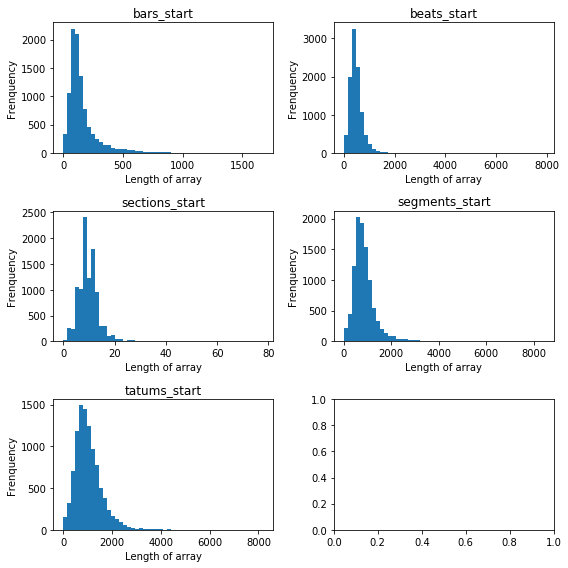

In [191]:
# Select the "start" variable of each type
start_list = [1, 3, 5, 11, 14]

fig, axes = plt.subplots(3, 2, figsize = (8, 8))
ax = axes.ravel()
for i, k in enumerate(start_list):
    ax[i].hist(array_lengths[k], bins = 50)
    ax[i].set_title(lookups[k])
    ax[i].set_xlabel('Length of array')
    ax[i].set_ylabel('Frenquency')
plt.tight_layout()

The segment pitches and timbre information comes in 12 vectors. 

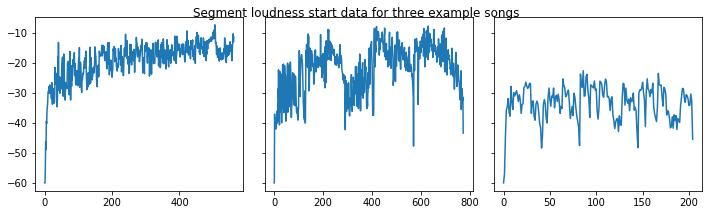

In [197]:

fig, axes = plt.subplots(1, 3, figsize = (10, 3), sharey = True)
ax = axes.ravel()
for i in range(3):
    ax[i].plot(subset_full['segments_loudness_start'][i])
plt.suptitle('Segment loudness start data for three example songs')
plt.tight_layout()

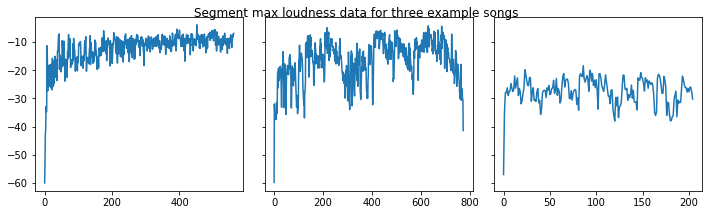

In [198]:
fig, axes = plt.subplots(1, 3, figsize = (10, 3), sharey = True)
ax = axes.ravel()
for i in range(3):
    ax[i].plot(subset_full['segments_loudness_max'][i])
plt.suptitle('Segment max loudness data for three example songs')
plt.tight_layout()

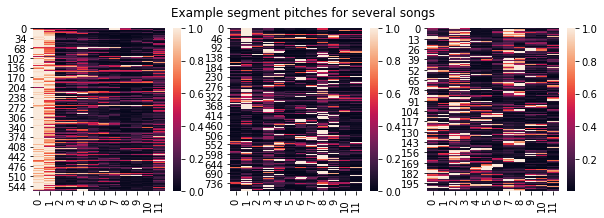

In [157]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 3))
sns.heatmap(subset_full['segments_pitches'][0], ax = ax1)
sns.heatmap(subset_full['segments_pitches'][1], ax = ax2)
sns.heatmap(subset_full['segments_pitches'][2], ax = ax3)
plt.suptitle('Segment pitches for three example songs');



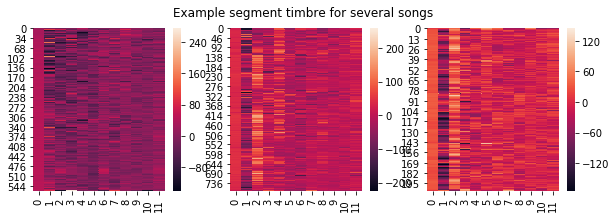

In [158]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 3))
sns.heatmap(subset_full['segments_timbre'][0], ax = ax1)
sns.heatmap(subset_full['segments_timbre'][1], ax = ax2)
sns.heatmap(subset_full['segments_timbre'][2], ax = ax3)
plt.suptitle('Segment timbre for three example songs');